## Neuređenost proteina u interaktomu<a id="par:toc"></a>

U radu je razmotren pojam interaktoma kao mreže proteinskih interakcija, kao i osobine i odnosi proteina u njemu. Konkretno, proučeni su interaktomi generisani na osnovu odabranog podskupa proteoma virusa *SARS-CoV-2* (membranski i nestrukturni proteini), a kao osobina od interesa izdvojena je neuređenost proteina u njima (prema različitim kriterijumima). Zadatak je bio uporediti stepen neuređenosti sa stepenom povezanosti čvora u grafu.

## Sadržaj

1. [Proteinska sekvenca](#par:protein)
2. [Neuređenost prema *IUPred*](#par:iupred)
3. [Interaktom prema *IntAct*](#par:intact)
4. [Poređenje osobina](#par:poriupred)
5. [Interaktom prema *iRefIndex*](#par:irefindex)
6. [Virusni interaktom](#par:virusni)
7. [Neuređenost prema profilu](#par:profil)
8. [Neuređenost prema *PONDR*](#par:pondr)
9. [Dužina neuređenih regiona](#par:regioni)
10. [Drugi kraj interakcije](#par:drugi)
11. [Dužina sekvence](#par:duzina)
12. [Najpovezaniji proteini](#par:habovi)

## 1. Proteinska sekvenca [⮭]<a id="par:protein"></a>

[⮭]: #par:toc

Mreža proteinskih interakcija sastoji se iz čvorova i neusmerenih veza (grana). Osnovu mreže čine čvorovi, zapravo proteini, predstavljeni sledećom klasom. Protein je jednoznačno određen svojim identifikatorom (npr. [*UniProtKB*](https://www.uniprot.org/uniprot/?query=reviewed:yes)), pa je to argument konstruktora. Pri konstrukciji se dohvata *FASTA* sekvenca, koja je zapravo lepo formatirani niz aminokiselina u više redova, dok prvi red sadrži određene metapodatke o dohvaćenom proteinu.

In [1]:
# Biblioteka za HTTP zahteve
import requests

# Biblioteka za rad sa fajl sistemom
import os, os.path

# Biblioteka za dohvatanje sekvence
from Bio import Entrez

# Postavljanje nekog bez veze mejla
Entrez.email = 'mejl@mejl.rs'

# Funkcija za sigurno otvaranje fajla
def fopen(fajl, mod):
    # Pravljenje potrebnih direktorijuma
    os.makedirs(os.path.dirname(fajl), exist_ok=True)
    
    # Otvaranje fajla u željenom modu
    return open(fajl, mod)

# Klasa koja predstavlja protein
class Protein:
    # Konstruktor na osnovu identifikatora
    def __init__(self, idd, uni=True):
        # Jedinstveni identifikator
        self.id = idd
        
        # Podatak da li je UniProtKB
        self.uni = uni
        
        # Sekvenca u FASTA formatu
        try:
            # Pokušaj čitanja sa lokala
            with open(f'../fasta/{self.idd()}.fasta', 'r') as f:
                self.fasta = f.read()
        except:
            try:
                # Dohvatanje sa NCBI
                self.fasta = Entrez.efetch(db='protein',
                                           id=self.idd(),
                                           rettype='fasta',
                                           retmode='text')\
                                   .read().strip()
            except:
                # Dohvatanje sa UniProt
                self.fasta = requests\
                             .get(f'https://www.uniprot.org/uniprot/{self.idd()}.fasta')\
                             .text.strip()
            
            # Upisivanje na lokal za ubuduće
            with fopen(f'../fasta/{self.idd()}.fasta', 'w') as f:
                f.write(self.fasta)
        
        # Podatak da li je ljudski
        self.ljudski = '_HUMAN' in self.fasta or 'Homo sapiens' in self.fasta
    
    # Dohvatanje dobrog indentifikatora za pretragu
    def idd(self):
        return self.id[:6] if '-PRO_' in self.id else self.id

Na primeru *M* (membranskog) proteina *SARS-CoV-2*, identifikovanog kao [*P0DTC5*](https://www.uniprot.org/uniprot/P0DTC5), dobija se sledeća sekvenca.

In [2]:
# Membranski protein
M = Protein('P0DTC5')

# UniProt identifikator
print(M.id)
print()

# FASTA sekvenca
print(M.fasta)

P0DTC5

>sp|P0DTC5.1|VME1_SARS2 RecName: Full=Membrane protein; Short=M; AltName: Full=E1 glycoprotein; AltName: Full=Matrix glycoprotein; AltName: Full=Membrane glycoprotein
MADSNGTITVEELKKLLEQWNLVIGFLFLTWICLLQFAYANRNRFLYIIKLIFLWLLWPVTLACFVLAAV
YRINWITGGIAIAMACLVGLMWLSYFIASFRLFARTRSMWSFNPETNILLNVPLHGTILTRPLLESELVI
GAVILRGHLRIAGHHLGRCDIKDLPKEITVATSRTLSYYKLGASQRVAGDSGFAAYSRYRIGNYKLNTDH
SSSSDNIALLVQ


## 2. Neuređenost prema *IUPred* [⮭]<a id="par:iupred"></a>

[⮭]: #par:toc

Za ispitivanje strukturiranosti proteina, sa [*IUPred*](https://iupred.elte.hu/) se dohvataju različiti lako dostupni skorovi neuređenosti, poput *PPIDR* (udeo neuređenih reziduuma). Konkretno, prediktor *IUPred* analizira niz aminokiselina ciljanog proteina i predviđa neuređene regione tako što procenjuje energetski potencijal za interakciju svakog reziduuma. S druge strane, prediktor *ANCHOR* predviđa neuređene regione sklone povezivanju sa drugim proteinima, pri čemu postaju uređeni.

In [3]:
# Biblioteka za JSON format
import json

# Biblioteka za računanje proseka
import numpy as np

# Predikcija neuređenosti
def idr(self):
    # Odustajanje ako nije UniProt
    if not self.uni: return
    
    try:
        # Pokušaj čitanja sa lokala
        with open(f'../iupred/{self.idd()}.json', 'r') as f:
            iupreds = json.load(f)
        
        # Upisivanje vrednosti
        for prop in iupreds:
            setattr(self, prop, iupreds[prop])
    except:
        # Vrednosti ANCHOR i IUPred (long) prediktora
        anchor = json.loads(requests
                            .get(f'https://iupred3.elte.hu/iupred3/anchor/{self.idd()}.json')
                            .text)

        # Niz ANCHOR vrednosti
        anchor2 = anchor['anchor2']

        # Prosek ANCHOR vrednosti
        self.anchor_mean = np.mean(anchor2)

        # Udeo neuređenosti prema ANCHOR
        self.anchor_ppidr = np.mean([x >= 0.5 for x in anchor2])

        # Niz IUPred (long) vrednosti
        iupredl = anchor['iupred2']

        # Prosek IUPred (long) vrednosti
        self.iupredl_mean = np.mean(iupredl)

        # Udeo neuređenosti prema IUPred (long)
        self.iupredl_ppidr = np.mean([x >= 0.5 for x in iupredl])

        # Vrednosti IUPred (short) prediktora
        iupreds = json.loads(requests
                             .get(f'https://iupred3.elte.hu/iupred3/short/{self.idd()}.json')
                             .text)['iupred2']

        # Prosek IUPred (short) vrednosti
        self.iupreds_mean = np.mean(iupreds)

        # Udeo neuređenosti prema IUPred (short)
        self.iupreds_ppidr = np.mean([x >= 0.5 for x in iupreds])
        
        # Upisivanje na lokal za ubuduće
        with fopen(f'../iupred/{self.idd()}.json', 'w') as f:
            json.dump({'anchor_mean': self.anchor_mean,
                       'anchor_ppidr': self.anchor_ppidr,
                       'iupredl_mean': self.iupredl_mean,
                       'iupredl_ppidr': self.iupredl_ppidr,
                       'iupreds_mean': self.iupreds_mean,
                       'iupreds_ppidr': self.iupreds_ppidr}, f)

# Postavljanje za metod klase
Protein.idr = idr

Na primeru *M* proteina, dobijaju se sledeći skorovi prediktora neuređenosti. Prva dvojka je *ANCHOR*, druga *IUPred3 (long)*, a treća *IUPred3 (short)*. Prvi član dvojke je prosek ocene za sve aminokiseline, a drugi udeo ocena većih od 0,5 (granica neuređenosti). *M* protein je očigledno dobro strukturiran.

In [4]:
# Računanje neuređenosti
M.idr()

# Neuređenost prema ANCHOR
print(M.anchor_mean)
print(M.anchor_ppidr)
print()

# Neuređenost prema IUPred (long)
print(M.iupredl_mean)
print(M.iupredl_ppidr)
print()

# Neuređenost prema IUPred (short)
print(M.iupreds_mean)
print(M.iupreds_ppidr)

0.10576046719480736
0.0

0.054983389227015005
0.0

0.10085534610528028
0.04954954954954955


Ostali proučavani prediktori neuređenosti jesu: familija [*PONDR*](http://www.pondr.com/), shema *CH-CDF*, [*Composition Profiler*](http://www.cprofiler.org/cgi-bin/profiler.cgi)... Oni, međutim, nemaju lep javni *API*, pa nisu pogodni za masovnu analizu velikog broja proteina. Slično važi za baze poput [*DisProt*](https://disprot.org/) ili [*D2P2*](https://d2p2.pro/), koje pritom ni ne sadrže mnoge proteine *SARS-CoV-2*.

## 3. Interaktom prema *IntAct* [⮭]<a id="par:intact"></a>

[⮭]: #par:toc

Prvi eksperiment razmatra interaktom prema bazi [*IntAct*](https://www.ebi.ac.uk/intact/search?query=P0DTC5). Za te potrebe se preuzima spisak interakcija iz te baze, na osnovu javnog *API*-ja. Na osnovu spiska interakcija, određuje se spisak interaktora (proteina sa kojima polazni protein interaguje), što je zapravo spisak čvorova traženog interaktoma.

In [5]:
# Spisak interaktora prema IntAct
def intact(self, skup=None):
    try:
        # Pokušaj čitanja sa lokala
        with open(f'../intact/{self.id}.json', 'r') as f:
                self.interakt = json.load(f)
    except:
        # Sve interakcije prema IntAct
        interaktom = json.loads(requests
                                .post(f'https://www.ebi.ac.uk/intact/ws/network/getInteractions?query={self.id}')
                                .text)['data']
        
        # Inicijalan skup interaktora
        self.interakt = {prot['data']['preferred_id'] for prot in interaktom
                         if prot['group'] == 'nodes' and prot['data']['preferred_id'] != self.id
                         and prot['data']['interactor_type'] == 'protein'}
        
        # Provera autointerakcije
        for inter in interaktom:
            if inter['group'] == 'edges' and inter['data']['source'] == inter['data']['target']:
                self.interakt.add(self.id)
        
        # Sortiranje svih interaktora
        self.interakt = sorted(self.interakt)
        
        # Upisivanje na lokal za ubuduće
        with fopen(f'../intact/{self.id}.json', 'w') as f:
            json.dump(self.interakt, f)
    
    # Eventualno filtriranje po skupu
    self.interakt = [prot for prot in self.interakt if skup is None or prot in skup]

# Postavljanje za metod klase
Protein.intact = intact

U konkretnom slučaju *M* proteina, dobija se 197 različitih interaktora, dok interaktom, naravno, sarži jedan čvor više (sam *M* protein).

In [6]:
# Određivanje interaktora prema IntAct
M.intact()

# Odštampan spisak interaktora M proteina
print(M.interakt)

['A4D1U4', 'A6NFN3', 'O00165', 'O00217', 'O00471', 'O00482', 'O14981', 'O15063', 'O15287', 'O15354', 'O15374', 'O43251', 'O43826', 'O43852', 'O43929', 'O60318', 'O60674', 'O75306', 'O75439', 'O75448', 'O75691', 'O75694', 'O75841', 'O75947', 'O75953', 'O76082', 'O94788', 'O94822', 'O94829', 'O94919', 'O95070', 'O95299', 'O95772', 'O95786', 'O95864', 'P00403', 'P01031', 'P05026', 'P05165', 'P05166', 'P07093', 'P07858', 'P08236', 'P0DTC6', 'P0DTC9', 'P0DTD1-PRO_0000449619', 'P0DTD1-PRO_0000449629', 'P11310', 'P11498', 'P13804', 'P16219', 'P19634', 'P20700', 'P24752', 'P25686', 'P27105', 'P27144', 'P35670', 'P38435', 'P38606', 'P42126', 'P42695', 'P45954', 'P48047', 'P48556', 'P49116', 'P49590', 'P49810', 'P51617', 'P51636', 'P51649', 'P54707', 'P78527', 'P78545', 'P98198', 'Q00765', 'Q03135', 'Q03169', 'Q05932', 'Q10713', 'Q13021', 'Q13114', 'Q13232', 'Q13608', 'Q14164', 'Q14653', 'Q15054', 'Q15386', 'Q15758', 'Q16236', 'Q16585', 'Q3MJ13', 'Q4KMQ2', 'Q53H96', 'Q53HI1', 'Q58EX7', 'Q5BJH7',

Kako je interaktom zapravo mreža (graf), neophodno je skupu izračunatih čvorova (proteina) pridružiti grane (veze), koje se opet mogu otkriti upitom ka razmatranoj bazi *IntAct*. Naime, za svaki protein iz grafa određuje se spisak svih interaktora. U mreži se zadržavaju one veze kod kojih su oba učesnika u spisku čvorova. Interaktom je tako predstavljem klasom u nastavku, koja dodatno podržava čuvanje u *JSON* i tabelarnom formatu.

In [7]:
# Biblioteka za rad sa tabelama
import pandas as pd

# Klasa koja predstavlja interaktom
class Interaktom:
    # Konstruktor na osnovu proteina
    def __init__(self, p, skup=None):
        # Forsiranje skupa proteina
        if isinstance(p, Protein):
            p = {p}
        
        # Određivanje neuređenosti
        # svih polaznih proteina
        for prot in p:
            prot.idr()
            
            # Određivanje suseda
            # polaznih proteina
            if prot.uni:
                prot.intact(skup)
            else:
                prot.irefindex(skup)
            
            # Veličina susedstva
            prot.susedi = len(prot.interakt)
        
        # Jedinstveni identifikatori
        self.ids = {pp.id for pp in p}
        
        # Skup svih potencijalnih interaktora
        skup = self.ids
        for pp in p:
            skup = {*skup, *pp.interakt}
        skup = sorted(skup)
        
        # Proteini prema identifikatoru u klasi
        self.prots = [Protein(prot, pp.uni) for prot in skup]
        
        # Određivanje neuređenosti
        # dohvaćenih proteina
        for prot in self.prots:
            prot.idr()
            
            # Određivanje suseda
            # dohvaćenih proteina
            if prot.uni:
                prot.intact(skup)
            else:
                prot.irefindex(skup)
            
            # Veličina susedstva
            prot.susedi = len(prot.interakt)
    
    # Čuvanje interaktoma na disku
    def sacuvaj(self, ime):
        # Čuvanje interaktoma u JSON formatu
        with fopen(f'../json/{ime}.json', 'w') as f:
            json.dump({prot.id: prot.interakt for prot in self.prots}, f)
        
        # Prazna tabela sa odgovarajućim kolonama
        tabela = pd.DataFrame(columns=['Broj suseda', 'Spisak suseda'])
        
        # Dodavanje svih proteina u tabelu
        for prot in self.prots:
            tabela.loc[prot.id] = [len(prot.interakt), prot.interakt]
        
        # Čuvanje interaktoma u tabelarnom formatu
        with fopen(f'../csv/{ime}.csv', 'w') as f:
            tabela.to_csv(f)
        
        # Prikaz tabele u svesci
        display(tabela)

Klasa se lako upotrebljava za predviđanje interaktoma razmatranog *M* proteina. Pri čuvanju se generiše tabela susedstva, koja je prikazana u nastavku.

In [8]:
# Interaktom M proteina
M_intact = Interaktom(M)

# Čuvanje u JSON formatu
M_intact.sacuvaj('M_IntAct')

,Broj suseda,Spisak suseda
A4D1U4,1,[P0DTC5]
A6NFN3,1,[P0DTC5]
O00165,1,[P0DTC5]
O00217,1,[P0DTC5]
O00471,6,"[O00471, P0DTC5, Q8TAG9, Q96A65, Q9UNE7, Q9UPT5]"
...,...,...
Q9Y672,1,[P0DTC5]
Q9Y6A1,1,[P0DTC5]
Q9Y6D5,4,"[P0DTC5, Q9BRK5, Q9UPT5, Q9Y6D6]"
Q9Y6D6,2,"[P0DTC5, Q9Y6D5]"


Moguće je nacrtati i samu rezultujuću mrežu, i to najbolje bez interakcija u kojima protein učestvuje sam sa sobom, kao i bez razmatranog proteina. Tako se bolje vidi povezanost ostalih čvorova, odnosno uočavaju eventualni habovi. U konkretnom slučaju *M* proteina, primetno je da je mreža donekle povezana. Što se tiče samog prikaza, postoji namerna razlika u boji čvorova: plavim kružićima označeni su ljudski, a narandžastim virusni proteini.

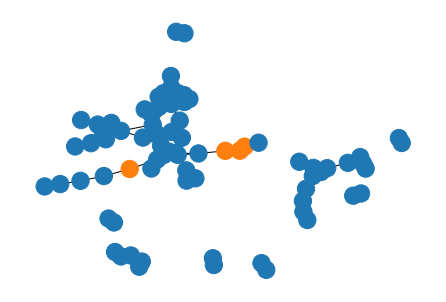

In [9]:
# Biblioteka za rad sa mrežama
import networkx as nx

# Određivanje boje čvorova
boja = lambda prot: '#1f77b4' if Protein(prot).ljudski else '#ff7f0e'

# Crtanje mreže pomoću biblioteke
def crtaj(fajl, skup):
    # Provera da li je mapa imena
    mapa = isinstance(skup, dict)
    
    # Učitavanje sačuvanog interaktoma
    with open(fajl, 'r') as f:
        inter = json.load(f)
    
    # Inicijalizacija grafa
    mreza = nx.Graph()
    
    # Prolazak kroz sve čvovore
    for k in inter:
        # Preskakanje gustih čvovora
        if not mapa and k in skup:
            continue
        
        # Prolazak kroz sve grane
        for v in inter[k]:
            # Preskakanje petlji i gustih cvorova
            if not mapa and v in skup or k == v:
                continue
            
            # Dodavanje grane u graf
            mreza.add_edge(k, v)
    
    # Inicijalno prazan spisak boja
    boje = []
    
    # Određivanje boje čvorova
    for node in mreza.nodes:
        boje.append(boja(node))
    
    # Sređivanje skupa
    skup = {k: skup[k] for k in skup if k in mreza.nodes}
    
    # Crtanje konačnog grafa
    if mapa:
        nx.draw(mreza, node_color=boje,
                labels=skup, with_labels=True)
    else:
        nx.draw(mreza, node_color=boje)

# Crtanje interaktoma M proteina
crtaj('../json/M_IntAct.json', M_intact.ids)

Moguće je napraviti i potpuno interaktivan graf, uz napomenu da je on gust i nepregledan za velike interaktome. U ovom grafu je, međutim, mišem moguće pomerati čvorove. Veličina čvorova srazmerna je povezanosti u interaktomu. Čvorovi koji predstavljaju virusne proteine označeni su kratkim simbolima (u vezi sa tim, u nastavku je dat spisak proteina *SARS-CoV-2*, podeljenih po grupama), dok su ljudski označeni *UniProtKB* ili *NCBI* identifikatorima. Prelazom mišem preko svakog čvora takođe se dobija njegov identifikator, sa stepenom povezanosti u zagradi. Podrazumevana topologija prikaza je zvezda.

In [10]:
# Biblioteka za interaktivne mreže
import pyvis.network as pyn

# Strukturni proteini i njihove UniProtKB oznake
SARS = {'P0DTC2': 'S', 'P0DTC4': 'E', 'P0DTC5': 'M', 'P0DTC9': 'N',
# Nestrukturni proteini i njihove NCBI oznake
        'YP_009725297': 'Nsp1' , 'YP_009725298': 'Nsp2' , 'YP_009725299': 'Nsp3' ,
        'YP_009725300': 'Nsp4' , 'YP_009725301': 'Nsp5' , 'YP_009725302': 'Nsp6' ,
        'YP_009725303': 'Nsp7' , 'YP_009725304': 'Nsp8' , 'YP_009725305': 'Nsp9' ,
        'YP_009725306': 'Nsp10', 'YP_009725307': 'Nsp12', 'YP_009725308': 'Nsp13',
        'YP_009725309': 'Nsp14', 'YP_009725310': 'Nsp15', 'YP_009725311': 'Nsp16',
# Pomoćni proteini i njihove UniProtKB oznake
        'P0DTC3': 'ORF3a', 'P0DTF1': 'ORF3b', 'P0DTG1': 'ORF3c', 'P0DTG0': 'ORF3d',
        'P0DTC6': 'ORF6' , 'P0DTC7': 'ORF7a', 'P0DTD8': 'ORF7b', 'P0DTC8': 'ORF8' ,
        'P0DTD2': 'ORF9b', 'P0DTD3': 'ORF9c', 'A0A663DJA2': 'ORF10'}

# Interaktivni interaktom
def pyvis(fajl, skup=set()):
    # Učitavanje sačuvanog interaktoma
    with open(fajl, 'r') as f:
        inter = json.load(f)
    
    # Inicijalizacija mreže
    mreza = pyn.Network('750px', '750px', notebook=True)
    
    # Prolazak kroz sve čvorove
    for k in inter:
        # Preskakanje gustih čvorova
        if k in skup: continue
        
        # Dodavanje ostalih čvorova
        mreza.add_node(k, title=f'{k} [{len(inter[k])}]',
                       color=boja(k), value=len(inter[k]),
                       label=SARS[k] if k in SARS else k)
    
    # Prolazak kroz sve čvovore
    for k in inter:
        # Preskakanje gustih čvovora
        if k in skup: continue
        
        # Prolazak kroz sve grane
        for v in inter[k]:
            # Preskakanje petlji i gustih cvorova
            if v in skup or skup and k == v:
                continue
            
            # Dodavanje grane u graf
            mreza.add_edge(k, v)
    
    # Isključivanje fizike
    mreza.toggle_physics(False)
    
    # Lociranje rezultujuće mreže
    fajl = fajl[:-5].replace('json', 'html') + \
           ('_part.html' if skup else '_full.html')
    
    # Pravljenje potrebnih direktorijuma
    os.makedirs(os.path.dirname(fajl), exist_ok=True)
    
    # Generisanje rezultujuće mreže
    mreza = mreza.show(fajl)
    
    # Prikaz rezultujuće mreže
    display(mreza)

# Crtanje interaktoma M proteina
pyvis('../json/M_IntAct.json')

Preglednosti radi, i ovde je moguće uprostiti mrežu isključivanjem razmatranog proteina, kao i autointerakcija. Preglednost, međutim, ostaje nezavidna.

In [11]:
# Crtanje interaktoma M proteina
pyvis('../json/M_IntAct.json', M_intact.ids)

## 4. Poređenje osobina [⮭]<a id="par:poriupred"></a>

[⮭]: #par:toc

Sada je moguće grafički uporediti stepen povezanosti čvora sa prethodno izračunatim stepenima neuređenosti. Poređenje je jednostavno: proteini su prikazani u dvodimenzionom prostoru, pri čemu je na horizontalnoj osi predstavljen stepen povezanosti u interaktomu (nenegativan ceo broj), dok vertikalna osa oslikava stepen neuređenosti istog proteina (realna vrednost između nule i jedinice). Po rezultatima se čini da mreža izgleda uobičajeno za jedan interaktom (npr. ima veliki broj čvorova malog stepena, ali i mali broj visokopovezanih čvorova), ali se ne primećuje jasna veza sa stepenom neuređenosti.

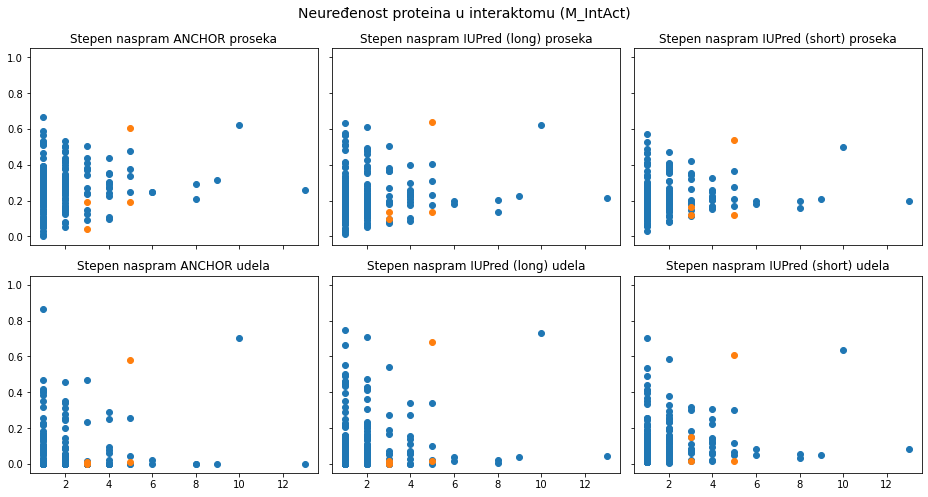

In [12]:
# Biblioteka za grafički prikaz
import matplotlib.pyplot as plt

# Indikator crtanja statistika
stat = False

# Crtanje proteina prema vrsti
def plotuj(X, Y, Z, ax, ime):
    # Prilagođavanje tipa podataka
    X = np.array(X)
    Y = np.array(Y)
    
    # Postavljanje naziva grafika
    ax.set_title(ime)
    
    # Dohvatanje vertikalne granice
    dno, vrh = ax.get_ylim()
    
    # Postavljanje vertikalne granice
    ax.set_ylim(min(-0.05, dno, -0.05 * max(Y)),
                max( 1.05, vrh,  1.05 * max(Y)))
    
    # Crtanje osnovnih statitika
    if stat:
        x, m, s = [], [], []

        # Prolazak kroz različite stepene
        for i in set(X):
            x.append(i)

            # Srednja vrednost na stepenu
            m.append(np.mean(Y[X == i]))

            # Standardno odstupanje na stepenu
            s.append(np.std(Y[X == i]))

        # Crtanje izračunatih statistika
        ax.errorbar(x, m, s,
                    linestyle='None',
                    marker='x', color='r')
    else:
        # Prilagođavanje tipa podataka
        Z = np.array(Z)

        # Crtanje ljudskih proteina
        ax.scatter(X[Z], Y[Z])

        # Crtanje neljudskih proteina
        ax.scatter(X[~Z], Y[~Z])

# Poređenje prema IntAct
def poredi(interakt, ime, ax=None):
    # Podela slike na više delova
    fig, axs = plt.subplots(2, 3, figsize=(13, 7),
                           sharex=True, sharey=True)

    # Inicijalno prazne liste koordinata
    X, Y, Z = [], [[[], [], []], [[], [], []]], []

    # Prolazak kroz sve proteine sem polaznih
    for prot in interakt.prots:
        if prot.id in interakt.ids:
            continue

        # Novi stepen povezanosti
        X.append(prot.susedi)
        
        # Novi podatak o poreklu proteina
        Z.append(prot.ljudski)

        # Nove ANCHOR mere neuređenosti
        Y[0][0].append(prot.anchor_mean)
        Y[1][0].append(prot.anchor_ppidr)

        # Nove IUPred (long) mere neuređenosti
        Y[0][1].append(prot.iupredl_mean)
        Y[1][1].append(prot.iupredl_ppidr)

        # Nove IUPred (short) mere neuređenosti
        Y[0][2].append(prot.iupreds_mean)
        Y[1][2].append(prot.iupreds_ppidr)

    # Crtanje svih određenih mera
    plotuj(X, Y[0][0], Z, axs[0, 0], 'Stepen naspram ANCHOR proseka')
    plotuj(X, Y[1][0], Z, axs[1, 0], 'Stepen naspram ANCHOR udela')
    plotuj(X, Y[0][1], Z, axs[0, 1], 'Stepen naspram IUPred (long) proseka')
    plotuj(X, Y[1][1], Z, axs[1, 1], 'Stepen naspram IUPred (long) udela')
    plotuj(X, Y[0][2], Z, axs[0, 2], 'Stepen naspram IUPred (short) proseka')
    plotuj(X, Y[1][2], Z, axs[1, 2], 'Stepen naspram IUPred (short) udela')
    
    # Naslov grafika koji opisuje sliku
    fig.suptitle(f'Neuređenost proteina u interaktomu ({ime})', fontsize=14)

    # Crtanje slike bez preklapanja
    fig.tight_layout()

# Poređenje prema IntAct
poredi(M_intact, 'M_IntAct')

Grafici mogu biti varljivi ukoliko se ne uzme u obzir tačna uslovna raspodela neuređenosti prema stepenu. Stoga je značajno posebno prikazati srednje vrednosti tih raspodela, a dodatno je korisno obogatiti prikaz ucrtavanjem standardnog odstupanja, što je i učinjeno u nastavku. Tako se tačno vidi koliko su proteini određenog stepena zapravo u globalu (prosečno) neuređeni, kao i koliko je ta procena stabilna (stabilnost ocene obrnuto je srazmerna odstupanju).

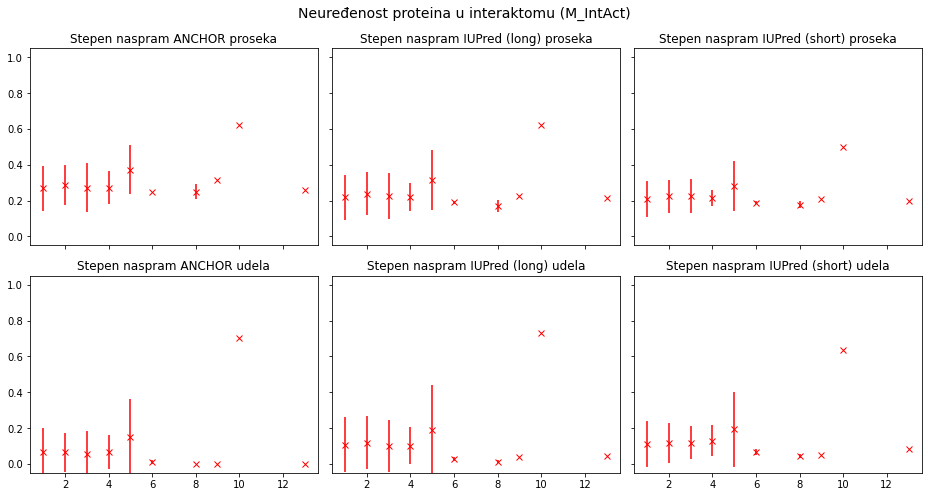

In [13]:
# Prikaz uslovnih raspodela
def statistike(interakt, ime, ax=None):
    # Dohvatanje globalne promenljive
    global stat
    
    # Postavljanje indikatora statistika
    stat = True
    
    # Statistike prema interaktomu
    poredi(interakt, ime, ax)
    
    # Poništavanje indikatora statistika
    stat = False

# Poređenje prema IntAct
statistike(M_intact, 'M_IntAct')

## 5. Interaktom prema *iRefIndex* [⮭]<a id="par:irefindex"></a>

[⮭]: #par:toc

Nestrukturni proteini *SARS-CoV-2*, koje kodira *ORF1ab*, nisu zabeležni u uobičajenim bazama proteina. Štaviše, čak ih i poznati *UniProt* uopšteno smatra jednim velikim poliproteinom, identifikovanim kao [*P0DTD1*](https://www.uniprot.org/uniprot/P0DTD1) (replikaza *1ab*). Ipak, njihovi *RefSeq* ([*NCBI*](https://www.ncbi.nlm.nih.gov/Structure/SARS-CoV-2.html)) identifikatori ih jednoznačno određuju.

In [14]:
# Nestrukturni proteini SARS-CoV-2
Nsp = {prot for prot in SARS if prot.startswith('YP_')}

# Nestrukturni proteini u klasi
Nsp = {Protein(nsp, False) for nsp in Nsp}

Njihove interakcije mogu se, međutim, naći na [*iRefIndex*](https://irefindex.vib.be/), odnosno preko objedinjenog sistema [*PSICQUIC*](http://www.ebi.ac.uk/Tools/webservices/psicquic/view/home.xhtml), i to takođe kroz javni *API*. Ova baza sadrži znatno veći broj interakcija od prethodno razmatrane *IntAct*, pri čemu je to jedna od najvećih baza povezanih sa *PSICQUIC*, tako da je vrlo korisna za rad.

In [15]:
# Biblioteka za čitanje iz niske
import io

# Spisak interaktora prema iRefIndex
def irefindex(self, skup=None):
    try:
        # Pokušaj čitanja sa lokala
        with open(f'../irefindex/{self.id}.json', 'r') as f:
                self.interakt = json.load(f)
    except:
        # Sve interakcije prema iRefIndex
        inter = io.StringIO(requests
                            .get(f'http://irefindex.vib.be/webservices/current/search/interactor/{self.id}')
                            .text)
        
        # Tabela svih interakcija prema spisku
        tabela = pd.read_table(inter, header=None) if inter.getvalue() else pd.DataFrame()

        # Inicijalno prazan skup interaktora
        self.interakt = set()

        # Prolazak kroz sve interakcije iz tabele
        for tab in tabela.iterrows():
            # Provera autointerakcije
            if tab[1][0] == tab[1][1]:
                self.interakt.add(self.id)
            
            # Provera ostalih interakcija
            for i in range(2):
                prot = tab[1][i]
                
                # Provera da li je protein
                pocetak = prot[:prot.find(':')]
                if pocetak not in ('uniprotkb', 'refseq'):
                    continue

                # Određivanje indentifikatora
                prot = prot[prot.find(':')+1:]

                # Dodavanje u skup interaktora
                if prot != self.id:
                    self.interakt.add(prot)
        
        # Sortiranje svih interaktora
        self.interakt = sorted(self.interakt)
        
        # Upisivanje na lokal za ubuduće
        with fopen(f'../irefindex/{self.id}.json', 'w') as f:
            json.dump(self.interakt, f)
    
    # Eventualno filtriranje po skupu
    self.interakt = [prot for prot in self.interakt if skup is None or prot in skup]

# Postavljanje za metod klase
Protein.irefindex = irefindex

I ovaj interaktom može se predvideti, sačuvati, prikazati tabelarno i nacrtati kao mreža (graf) sa odabranim čvorovima i granama.

In [16]:
# Interaktom nestrukturnih proteina
Nsp_iref = Interaktom(Nsp)

# Čuvanje u JSON formatu
Nsp_iref.sacuvaj('Nsp_iRef')

,Broj suseda,Spisak suseda
A0A024QYX0,9,"[A0A024QYX0, O43169, Q969E2, Q9BSR8, XP_005269..."
A0A024QZF1,11,"[A0A024QZF1, A0A024R6Y2, P11021, Q8TEM1, XP_00..."
A0A024R1U4,10,"[A0A024R7I3, A0A024R7V6, A0A158RFU6, B7Z8M7, P..."
A0A024R2W3,13,"[A0A024R2W3, A0A024R712, A0A384N6C2, O43823, O..."
A0A024R324,10,"[A0A024R324, A0A024R6Y2, A0A140VJJ8, P0CG48, P..."
...,...,...
YP_009725307,24,"[A0A0S2Z4C3, A3KN83, O43823, O75592, O95391, Q..."
YP_009725308,41,"[A0A024R2W3, A0A024R712, A0A0A6YZ17, A4D0Z4, A..."
YP_009725309,8,"[A0A384N6C2, P06280, P0DTC6, Q86TG7, XP_005272..."
YP_009725310,9,"[A0A024R3X9, A0A024R6Y2, P62330, Q96HP0, Q9H4P..."


Graf ima 311 čvorova. Čini se da je ova mreža, nastala prema nestrukturnim proteinima, znatno povezanija od one nastale prema dobro strukturiranom membranskom proteinu. Iako prikaz nije preterano pregledan, primetan je vidno veći broj grana, predstavljenih crnim linijama između čvorova.

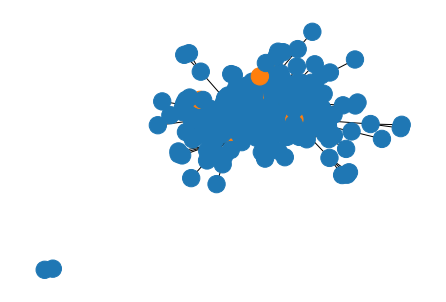

In [17]:
# Crtanje interaktoma nestrukturnih proteina
crtaj('../json/Nsp_iRef.json', Nsp_iref.ids)

I ovde je moguće napraviti interaktivnu mrežu, takođe uz napomenu o slaboj preglednosti prikaza, što je sada još izraženije.

In [18]:
# Crtanje interaktoma nestrukturnih proteina
pyvis('../json/Nsp_iRef.json')

Još jednom je moguće pokušati sa poboljšanjem preglednosti tako što se izbace polazni proteini i autointerakcije.

In [19]:
# Crtanje interaktoma nestrukturnih proteina
pyvis('../json/Nsp_iRef.json', Nsp_iref.ids)

Ista baza može se iskoristiti za pravljenje drugog interaktoma zasnovanog na membranskom proteinu, umesto prethodne *IntAct*.

In [20]:
# Novi pogled na M protein
M2 = Protein('P0DTC5', False)

# Novi interaktom M proteina
M_iref = Interaktom(M2)

# Čuvanje u JSON formatu
M_iref.sacuvaj('M_iRef')

,Broj suseda,Spisak suseda
A0A024R071,4,"[A0A024R071, P0DTC5, Q8WUM0, Q9BW27]"
A0A024R374,5,"[A0A024R374, P0DTC2, P0DTC5, XP_011517282, XP_..."
A0A024R3H9,1,[P0DTC5]
A0A024R3U8,8,"[A0A024R3U8, O75306, O75439, O75947, P0DTC5, X..."
A0A024R438,3,"[A0A024R438, P0DTC5, Q9UHD2]"
...,...,...
XP_016872628,1,[P0DTC5]
XP_016876117,2,"[P0DTC5, P25686]"
XP_016879599,1,[P0DTC5]
XP_016882939,1,[P0DTC5]


Ova mreža ima 211 čvorova, nešto više od prethodnih 198, ali je takođe primetno povezanija. Ovo se u suštini može shvatiti kao značajniji rezultat u kontekstu dalje analize strukture grafa, a posledica je većeg obima posmatrane baze *iRefIndex*, što je, kako je već pomenuto, njena velika prednost.

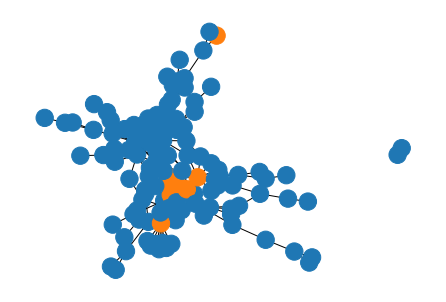

In [21]:
# Crtanje interaktoma M proteina
crtaj('../json/M_iRef.json', M_iref.ids)

Još jednom je moguće napraviti interaktivnu mrežu, takođe uz napomenu o slaboj preglednosti prikaza.

In [22]:
# Crtanje interaktoma M proteina
pyvis('../json/M_iRef.json')

Naravno, opet nije loše pokušati sa poboljšanjem preglednosti isključivanjem gustih čvorova iz prikaza.

In [23]:
# Crtanje interaktoma M proteina
pyvis('../json/M_iRef.json', M_iref.ids)

## 6. Virusni interaktom [⮭]<a id="par:virusni"></a>

[⮭]: #par:toc

Prethodni interaktomi sadržali su kako virusne, tako i ljudske proteine. Moguće je ograničiti se samo na virusne, što je u nastavku urađeno i ilustrovano.

In [24]:
# Svi proteini u klasi
SARS_proteom = {Protein(prot, False) for prot in SARS}

# Interaktom svih proteina
SARS_iref = Interaktom(SARS_proteom, SARS_proteom)

# Čuvanje u JSON formatu
SARS_iref.sacuvaj('SARS_iRef')

,Broj suseda,Spisak suseda
A0A663DJA2,4,"[A0A663DJA2, P0DTC3, P0DTC5, P0DTC9]"
P0DTC2,3,"[P0DTC2, P0DTC4, P0DTC5]"
P0DTC3,6,"[A0A663DJA2, P0DTC3, P0DTC4, P0DTC7, P0DTD8, Y..."
P0DTC4,5,"[P0DTC2, P0DTC3, P0DTC4, P0DTC9, P0DTD2]"
P0DTC5,7,"[A0A663DJA2, P0DTC2, P0DTC5, P0DTC6, P0DTC7, P..."
P0DTC6,5,"[P0DTC5, P0DTC6, P0DTC7, YP_009725299, YP_0097..."
P0DTC7,7,"[P0DTC3, P0DTC5, P0DTC6, P0DTC7, P0DTC9, P0DTD..."
P0DTC8,2,"[P0DTC8, YP_009725304]"
P0DTC9,6,"[A0A663DJA2, P0DTC4, P0DTC5, P0DTC7, P0DTC9, Y..."
P0DTD2,3,"[P0DTC4, P0DTC7, P0DTD2]"


Kao i dosad, pored tabelarnog prikaza, moguće je mrežu predstaviti i u pravom svetlu: kao sliku sa čvorovima i vezama.

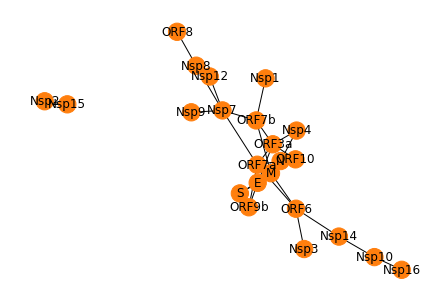

In [25]:
# Crtanje interaktoma nestrukturnih proteina
crtaj('../json/SARS_iRef.json', SARS)

Sada ima više smisla generisati i interaktivnu mrežu, jer u slučaju malog interaktoma nije previše gusta i nepregledna, pa se može lako analizirati. Glavna razlika je što boja ovde zavisi od tipa proteina (strukturni su svetloplavi, nestrukturni narandžasti, a pomoćni ljubičasti), pošto su sada svakako svi virusni.

In [26]:
# Određivanje boje prema tipu
def boja(prot):
    if SARS[prot].startswith('Nsp'):
        return '#f89868'
    elif SARS[prot].startswith('ORF'):
        return '#7392ca'
    else:
        return '#8bd4e3'

# Interaktivni interaktom
pyvis('../json/SARS_iRef.json')

Rezultate je moguće porediti sa nekim drugim interaktomom, npr. onim iz nastavka. Primetno je da su vrlo slični, mada postoje određene razlike.

<img src='../slike/SARS_Gao.png' width='75%'>

## 7. Neuređenost prema profilu [⮭]<a id="par:profil"></a>

[⮭]: #par:toc

Iako [*Composition Profiler*](http://www.cprofiler.org/cgi-bin/profiler.cgi) nema lep *API* za automatizovan rad, moguće je programatski ga oponašati. Ideja je uporediti udele aminokiselina sa referentnim udelima iz neke opšte i neke baze neuređenih proteina. Zapravo se za svaku aminokiselinu provera da li je sekvenca obogaćena njome ili osiromašena. Ovom prilikom izračunato je pet različitih mera, koje će biti objašnjene u trenutku kada budu grafički prikazane u odnosu na stepen povezanosti.

In [27]:
# Referentni udeli aminokiselina
aa = ['A', 'N', 'C', 'Q', 'E', 'H', 'I', 'L', 'K' , 'M', 'F', 'P', 'S', 'W', 'Y', 'V']
pdb = [0.0770, 0.0458, 0.0174, 0.0395, 0.0665, 0.0241, 0.0561, 0.0868,
       0.0637, 0.0222, 0.0398, 0.0457, 0.0619, 0.0144, 0.0350, 0.0672]
dp = [0.0810, 0.0382, 0.0080, 0.0527, 0.0989, 0.0193, 0.0324, 0.0622,
      0.0785, 0.0187, 0.0244, 0.0811, 0.0865, 0.0067, 0.0213, 0.0541]

# Generisanje skupa 'neuređenih' kiselina
neur = {amino for amino, norm, dis in zip(aa, pdb, dp) if norm < dis}

# Aminokiselinski profil kao udeo neuređenih
def profil(self):
    try:
        # Pokušaj čitanja sa lokala
        with open(f'../profil/{self.idd()}.json', 'r') as f:
            prof = json.load(f)
        
        # Upisivanje vrednosti
        for prop in prof:
            setattr(self, prop, prof[prop])
    except:
        # Sekvenca prema FASTA formatu
        sekvenca = self.fasta[self.fasta.find('\n'):].replace('\n', '')
        
        # Inicijalno prazan niz razlika
        razlike = [[], []]
        
        # Inicijalno nulti udeo prema uređenosti
        self.prof_ppidr = 0
        
        # Prolazak kroz svaku aminokiselinu
        for amino, norm, dis in zip(aa, pdb, dp):
            # Prebrojavanje tekuće kiseline
            tren = sekvenca.count(amino) / len(sekvenca)
            
            # Dodavanje ako je 'neuređena'
            if norm < dis:
                self.prof_ppidr += tren
            
            # Provera kojoj grupi je udeo bliži
            razlike[0].append(abs(tren-norm) - abs(tren-dis))
            razlike[1].append(razlike[0][-1] > 0)
        
        # Uprosečavanje razlika (bliskosti)
        self.prof_hard = int(np.mean(razlike[0]) > 0)
        self.prof_soft = np.mean(razlike[1])
        
        # Inicijalizacija broja neuređenih regiona
        self.prof_reg5 = 0
        self.prof_reg31 = 0
        
        # Dužina tekućeg regiona
        i = 0
        
        # Brojanje neuređenih regiona u sekvenci
        for c in sekvenca:
            # Produžavanje neuređenog regiona
            if c in neur:
                i += 1
            else:
                # Regioni dužine makar pet
                if i >= 5:
                    self.prof_reg5 += 1
                
                # Regioni dužine preko trideset
                if i > 30:
                    self.prof_reg31 += 1
                
                # Kraj neuređenog regiona
                i = 0
        
        # Regioni dužine makar pet
        if i >= 5:
            self.prof_reg5 += 1
        
        # Regioni dužine preko trideset
        if i > 30:
            self.prof_reg31 += 1
        
        # Upisivanje na lokal za ubuduće
        with fopen(f'../profil/{self.idd()}.json', 'w') as f:
            json.dump({'prof_hard': self.prof_hard,
                       'prof_soft': self.prof_soft,
                       'prof_ppidr': self.prof_ppidr,
                       'prof_reg5': self.prof_reg5,
                       'prof_reg31': self.prof_reg31}, f)

# Postavljanje za metod klase
Protein.profil = profil

Još jednom je moguće grafički uporediti stepen povezanosti čvora sa prethodno izračunatim stepenima neuređenosti prema profilu. Svaka kolona predstavlja jedan interaktom, označen u zagradi naslova grafika. Svaki red, s druge strane, predstavlja jednu prikazanu meru. U konkretnom slučaju, prva mera je 'tvrdi' profil, koji zapravo predstavlja neotežani udeo (indikator bliskosti) aminokiselina u proteinu čija je raspodela bliža bazi neuređenih proteina *DisProt* nego opštoj bazi (skupu *PDB Select 25*). Druga mera je 'meki' profil, što je isti udeo, samo otežan tako da statistički značajnija obogaćenja i osiromašenja više doprinose rezultatu (sada je to realna vrednost, a ne indikator). Treća mera je jednostavan (neotežani) udeo aminokiselina koje su prisutnije u neuređenim proteinima. Po rezultatima se i ovoga puta čini da mreže izgledaju uobičajeno za jedan interaktom, ali se takođe ne primećuje jasna veza povezanosti sa neuređenošću.

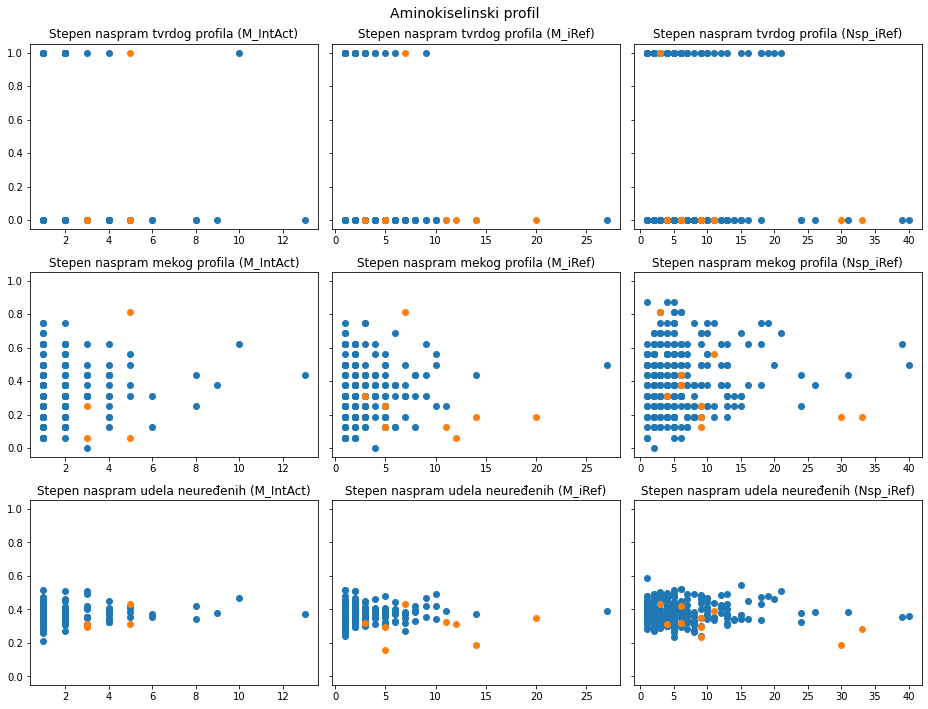

In [28]:
# Podela slike na više delova
fig, axs = plt.subplots(3, 3,
                      figsize=(13, 10),
                      sharey=True)

# Naslov grafika koji opisuje sliku
fig.suptitle('Aminokiselinski profil', fontsize=14)

# Poređenje prema profilu
def poredi(interakt, ime, axs):
    # Inicijalno prazne liste koordinata
    X, Y, Z = [], [[], [], []], []

    # Prolazak kroz sve proteine
    for prot in interakt.prots:
        # Određivanje profila
        prot.profil()
        
        # Preskakanje polaznih
        if prot.id in interakt.ids:
            continue

        # Novi stepen povezanosti
        X.append(prot.susedi)
        
        # Novi podatak o poreklu proteina
        Z.append(prot.ljudski)

        # Nove mere prema profilu
        Y[0].append(prot.prof_hard)
        Y[1].append(prot.prof_soft)
        Y[2].append(prot.prof_ppidr)
    
    # Crtanje mera prema profilu
    plotuj(X, Y[0], Z, axs[0], f'Stepen naspram tvrdog profila ({ime})')
    plotuj(X, Y[1], Z, axs[1], f'Stepen naspram mekog profila ({ime})')
    plotuj(X, Y[2], Z, axs[2], f'Stepen naspram udela neuređenih ({ime})')

# Poređenje prema profilu
poredi(M_intact, 'M_IntAct', axs[:, 0])
poredi(M_iref, 'M_iRef', axs[:, 1])
poredi(Nsp_iref, 'Nsp_iRef', axs[:, 2])

# Crtanje slike bez preklapanja
fig.tight_layout()

I ovde su prikazani srednja vrednost i standardno odstupanje uslovne raspodele neuređenosti proteina prema stepenu povezanosti čvora. Kao značajan rezultat izdvaja se udeo aminokiselina prisutnijih u neuređenim proteinima. Naime, ova mera relativno stabilno raste zajedno sa porastom stepena povezanosti otprilike do stepena deset (interaktom prema membranskom proteinu) ili dvadeset (interaktom prema nestrukturnim proteinima). Nakon toga, sledi nagli pad. Statistički gledano, prema tome se čini da je zajednička raspodela povezanosti i neuređenosti negativno asimetrična. Ova mera je, takođe, prilično stabilna (slabo varijabilna), što se vidi po niskom standardnom odstupanju, pa je time automatski najpogodnija za zaključivanje o odnosu raspodela.

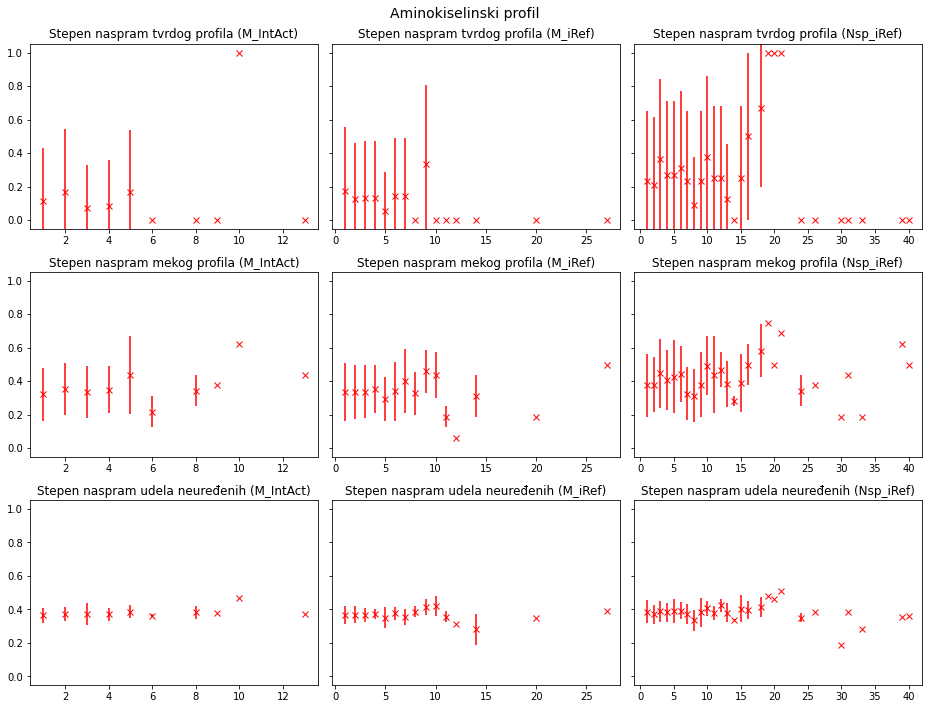

In [29]:
# Podela slike na više delova
fig, axs = plt.subplots(3, 3,
                      figsize=(13, 10),
                      sharey=True)

# Naslov grafika koji opisuje sliku
fig.suptitle('Aminokiselinski profil', fontsize=14)

# Statistike prema profilu
statistike(M_intact, 'M_IntAct', axs[:, 0])
statistike(M_iref, 'M_iRef', axs[:, 1])
statistike(Nsp_iref, 'Nsp_iRef', axs[:, 2])

# Crtanje slike bez preklapanja
fig.tight_layout()

## 8. Neuređenost prema *PONDR* [⮭]<a id="par:pondr"></a>

[⮭]: #par:toc

Iako ni [*PONDR*](http://www.pondr.com/) nema lep *API* za automatizovan rad, moguće je programatski oponašati ručno dohvatanje rezultata preko formulara. Sada je manipulacijom *HTTP* zahtevima preuzeto šest različitih mera, koje će biti objašnjene u trenutku kada budu grafički prikazane u odnosu na stepen povezanosti.

In [30]:
# Biblioteka za regularne izraze
import re

# Biblioteka za lepo formatiranje
import bs4

# Biblioteka za rad sa formularima
import mechanize

# Aktivni veb-pregledač (brauzer)
br = mechanize.Browser()

# Upotreba PONDR prediktora neuređenosti
def pondr(self):
    try:
        # Pokušaj čitanja sa lokala
        with open(f'../pondr/{self.idd()}.json', 'r') as f:
            pondrs = json.load(f)
        
        # Upisivanje vrednosti
        for prop in pondrs:
            setattr(self, prop, pondrs[prop])
    except:
        # PONDR veb-stranica
        br.open('http://www.pondr.com/')
        
        # Formular za zahtev
        br.select_form(nr=1)
        
        # Označena hidropatija
        br['CH'] = ['on']
        
        # Idektifikator proteina
        br['AccessionCode'] = self.id
        
        # Sekvenca proteina
        br['Sequence'] = self.fasta.replace('U', '')
        
        # Rezultat PONDR zahteva
        odgovor = bs4.BeautifulSoup(br.submit().read(),
                                    features='html5lib').prettify()
        
        # Informacije o VLXT prediktoru
        vlxt = re.search(r'Overall percent disordered: (.*?)\t'
                         r'Average Prediction Score: (.*?)\n', odgovor)\
                 .groups()
        
        # Upisivanje vrednosti
        self.vlxt_mean = float(vlxt[1])
        self.vlxt_ppidr = float(vlxt[0]) / 100
        
        # Informacije o hidropatiji
        ch = re.search(r'Hydropathy: (.*?)\t'
                       r'Boundary Hydropathy=(.*?)\n', odgovor)\
                .groups()
        
        # Upisivanje vrednosti
        self.ch_val = float(ch[0])
        self.ch_ind = int(float(ch[0]) < float(ch[1]))
        
        # Inicijalizacija broja neuređenih regiona
        self.vlxt_reg5 = 0
        self.vlxt_reg31 = 0
        
        # Informacije o neuređenim regionima
        for i, j in re.findall(r'Predicted disorder segment \[(\d+)]-\[(\d+)]', odgovor):
            # Dužina neuređenog regiona
            reg = int(j) - int(i) + 1
            
            # Regioni dužine makar pet
            if reg >= 5:
                self.vlxt_reg5 += 1
            
            # Regioni dužine preko trideset
            if reg > 30:
                self.vlxt_reg31 += 1
        
        # Upisivanje na lokal za ubuduće
        with fopen(f'../pondr/{self.idd()}.json', 'w') as f:
            json.dump({'vlxt_mean': self.vlxt_mean,
                       'vlxt_ppidr': self.vlxt_ppidr,
                       'ch_val': self.ch_val,
                       'ch_ind': self.ch_ind,
                       'vlxt_reg5': self.vlxt_reg5,
                       'vlxt_reg31': self.vlxt_reg31}, f)

# Postavljanje za metod klase
Protein.pondr = pondr

I ovde se grafički poredi stepen povezanosti čvora sa prethodno izračunatim *PONDR* skorovima: *VLXT* i *CH* (hidropatija). Konkretno, prva mera jeste prosečan *VLXT* skor po aminokiselini, dok je druga udeo *VLXT* skorova većih od praga 0,5. Ovaj prediktor zapravo integriše tri nepovratne (*feedforward*) neuronske mreže: *VL1*, *XN* i *XC*, koje su trenirane nad podacima dobijenim rendgenskom kristalografijom. Prolazom kroz aminokiselinski niz, prediktor svakom reziduumu dodeljuje ocenu neuređenosti. Treća prikazana mera jeste hidropatija, koja apstrahuje kompaktnost proteina. Činjenica je da hidrofobniji proteini imaju čvršću strukturu, što znači da su stabilniji, a samim tim i uređeniji. Poslednja mera jeste rezultat *CH* predikcije, koja predviđa neuređenost proteina na osnovu kombinacije hidropatije i srednjeg naelektrisanja (naelektrisaniji proteini su nestabilniji). Po rezultatima se još jednom čini da mreže izgledaju uobičajeno za jedan interaktom, ali se u svakom slučaju ne primećuje jasna veza stepena čvora sa neuređenosti predstavljenog proteina.

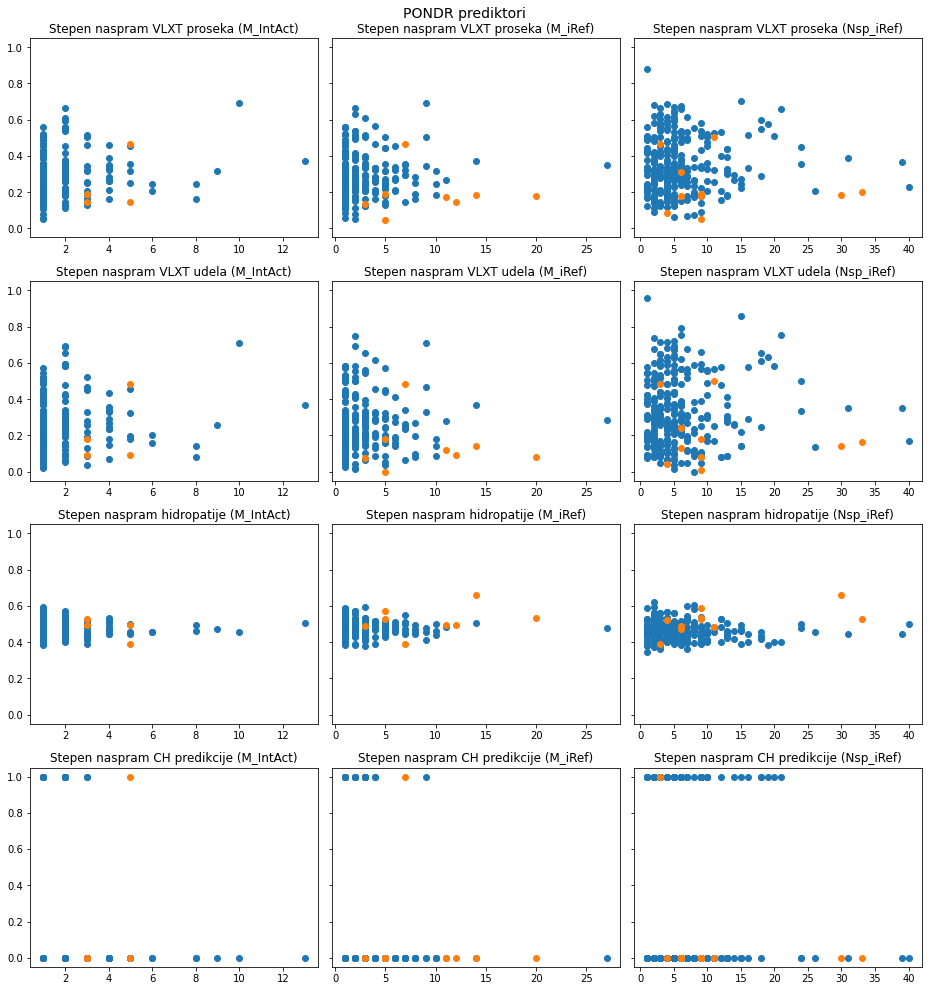

In [31]:
# Podela slike na više delova
fig, axs = plt.subplots(4, 3,
                        figsize=(13, 14),
                        sharey=True)

# Naslov grafika koji opisuje sliku
fig.suptitle('PONDR prediktori', fontsize=14)

# Poređenje prema PONDR skorovima
def poredi(interakt, ime, axs):
    # Inicijalno prazne liste koordinata
    X, Y, Z = [], [[], [], [], []], []

    # Prolazak kroz sve proteine
    for prot in interakt.prots:
        # Određivanje PONDR skorova
        prot.pondr()
        
        # Preskakanje polaznih
        if prot.id in interakt.ids:
            continue

        # Novi stepen povezanosti
        X.append(prot.susedi)
        
        # Novi podatak o poreklu proteina
        Z.append(prot.ljudski)

        # Nove mere prema PONDR skorovima
        Y[0].append(prot.vlxt_mean)
        Y[1].append(prot.vlxt_ppidr)
        Y[2].append(prot.ch_val)
        Y[3].append(prot.ch_ind)
    
    # Crtanje mera prema PONDR
    plotuj(X, Y[0], Z, axs[0], f'Stepen naspram VLXT proseka ({ime})')
    plotuj(X, Y[1], Z, axs[1], f'Stepen naspram VLXT udela ({ime})')
    plotuj(X, Y[2], Z, axs[2], f'Stepen naspram hidropatije ({ime})')
    plotuj(X, Y[3], Z, axs[3], f'Stepen naspram CH predikcije ({ime})')

# Poređenje prema PONDR skorovima
poredi(M_intact, 'M_IntAct', axs[:, 0])
poredi(M_iref, 'M_iRef', axs[:, 1])
poredi(Nsp_iref, 'Nsp_iRef', axs[:, 2])

# Crtanje slike bez preklapanja
fig.tight_layout()

Takođe su ilustrovane osnovne statistike uslovne raspodele neuređenosti proteina prema stepenu povezanosti čvora. Ovo je posebno važno u slučaju *CH* predikcije, jer van toga ima samo vrednosti jedan i nula, pa nije moguće lako videti kolika je u globalu neuređenost posmatrane grupe po povezanosti.

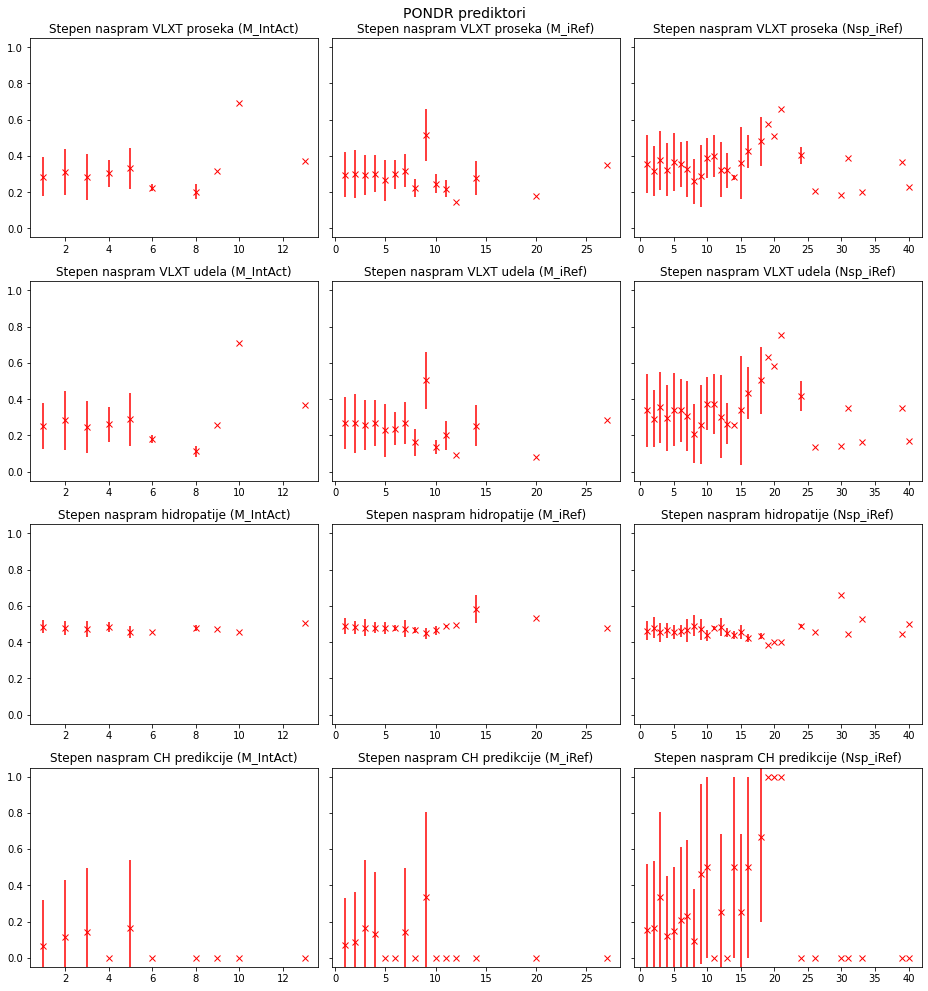

In [32]:
# Podela slike na više delova
fig, axs = plt.subplots(4, 3,
                        figsize=(13, 14),
                        sharey=True)

# Naslov grafika koji opisuje sliku
fig.suptitle('PONDR prediktori', fontsize=14)

# Statistike prema PONDR skorovima
statistike(M_intact, 'M_IntAct', axs[:, 0])
statistike(M_iref, 'M_iRef', axs[:, 1])
statistike(Nsp_iref, 'Nsp_iRef', axs[:, 2])

# Crtanje slike bez preklapanja
fig.tight_layout()

## 9. Dužina neuređenih regiona [⮭]<a id="par:regioni"></a>

[⮭]: #par:toc

Neuređenost proteina može se meriti i prema broju dugačkih *IDR* (neuređeni regioni), koji podrazumevaju grupe susednih neuređenih reziduuma. Eksperimentalno su značajni kratki neuređeni regioni dužine ne manje od pet, dok su još značajni oni dužine veće od trideset. Broj ovakvih regiona izračunat je prema profilu i prema prediktoru *VLXT* u prethodnim koracima, a sada dolazi na red grafički prikaz ovih mera. Prikazano je šest različitih. Prva je broj neuređenih regiona dužine makar pet prema profilu, pri čemu se neuređenim regionima smatraju nizovi uzastopnih aminokiselina statistički prisutnijih u neuređenim proteinima. Druga je broj neuređenih regiona dužine preko trideset takođe prema profilu. Treća je udeo regiona dužih od trideset u svim regionima dužine makar pet. Sledi broj regiona dužine ne manje od pet prema *VLXT* prediktoru, pri čemu se neuređenim regionima smatraju nizovi uzastopnih aminokiselina sa vrednošću prediktora većom od polovine, zatim broj regiona dužine preko trideset prema istom kriterijumu, a na kraju udeo većih regiona u svim neuređenim regionima, slično kao u slučaju profila. Donekle se čini da slabije povezani proteini imaju veći broj neuređenih regiona.

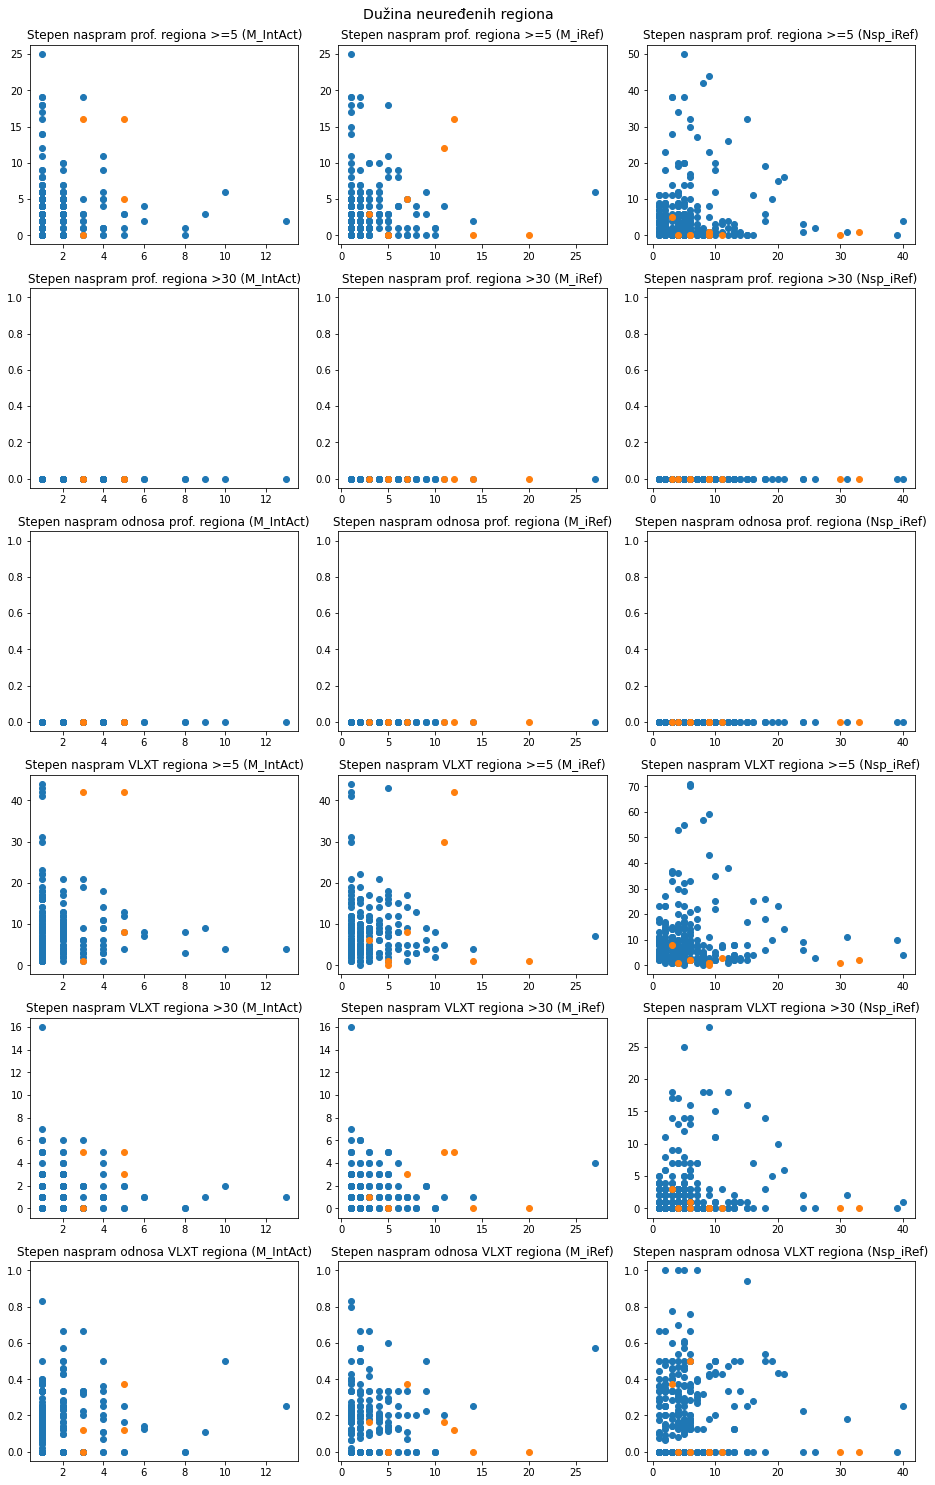

In [33]:
# Podela slike na više delova
fig, axs = plt.subplots(6, 3, figsize=(13, 21))

# Naslov grafika koji opisuje sliku
fig.suptitle('Dužina neuređenih regiona\n', fontsize=14)

# Poređenje prema PONDR skorovima
def poredi(interakt, ime, axs):
    # Inicijalno prazne liste koordinata
    X, Y, Z = [], [[], [], [], [], [], []], []

    # Prolazak kroz sve proteine
    for prot in interakt.prots:
        # Preskakanje polaznih
        if prot.id in interakt.ids:
            continue

        # Novi stepen povezanosti
        X.append(prot.susedi)
        
        # Novi podatak o poreklu proteina
        Z.append(prot.ljudski)

        # Nove dužine neuređenih regiona
        Y[0].append(prot.prof_reg5)
        Y[1].append(prot.prof_reg31)
        Y[2].append(Y[1][-1] / Y[0][-1] if Y[0][-1] else 0)
        Y[3].append(prot.vlxt_reg5)
        Y[4].append(prot.vlxt_reg31)
        Y[5].append(Y[4][-1] / Y[3][-1] if Y[3][-1] else 0)
    
    # Crtanje mera prema regionima
    plotuj(X, Y[0], Z, axs[0], f'Stepen naspram prof. regiona >=5 ({ime})')
    plotuj(X, Y[1], Z, axs[1], f'Stepen naspram prof. regiona >30 ({ime})')
    plotuj(X, Y[2], Z, axs[2], f'Stepen naspram odnosa prof. regiona ({ime})')
    plotuj(X, Y[3], Z, axs[3], f'Stepen naspram VLXT regiona >=5 ({ime})')
    plotuj(X, Y[4], Z, axs[4], f'Stepen naspram VLXT regiona >30 ({ime})')
    plotuj(X, Y[5], Z, axs[5], f'Stepen naspram odnosa VLXT regiona ({ime})')

# Poređenje prema PONDR skorovima
poredi(M_intact, 'M_IntAct', axs[:, 0])
poredi(M_iref, 'M_iRef', axs[:, 1])
poredi(Nsp_iref, 'Nsp_iRef', axs[:, 2])

# Crtanje slike bez preklapanja
fig.tight_layout()

U nastavku su prikazani srednja vrednost i standardno odstupanje uslovne raspodele neuređenosti proteina prema stepenu povezanosti čvora. Još jednom se čini da u interaktomu prema nestrukturnim proteinima prosek neuređenosti donekle raste uz porast stepena povezanosti, nakon čega naglo opada.

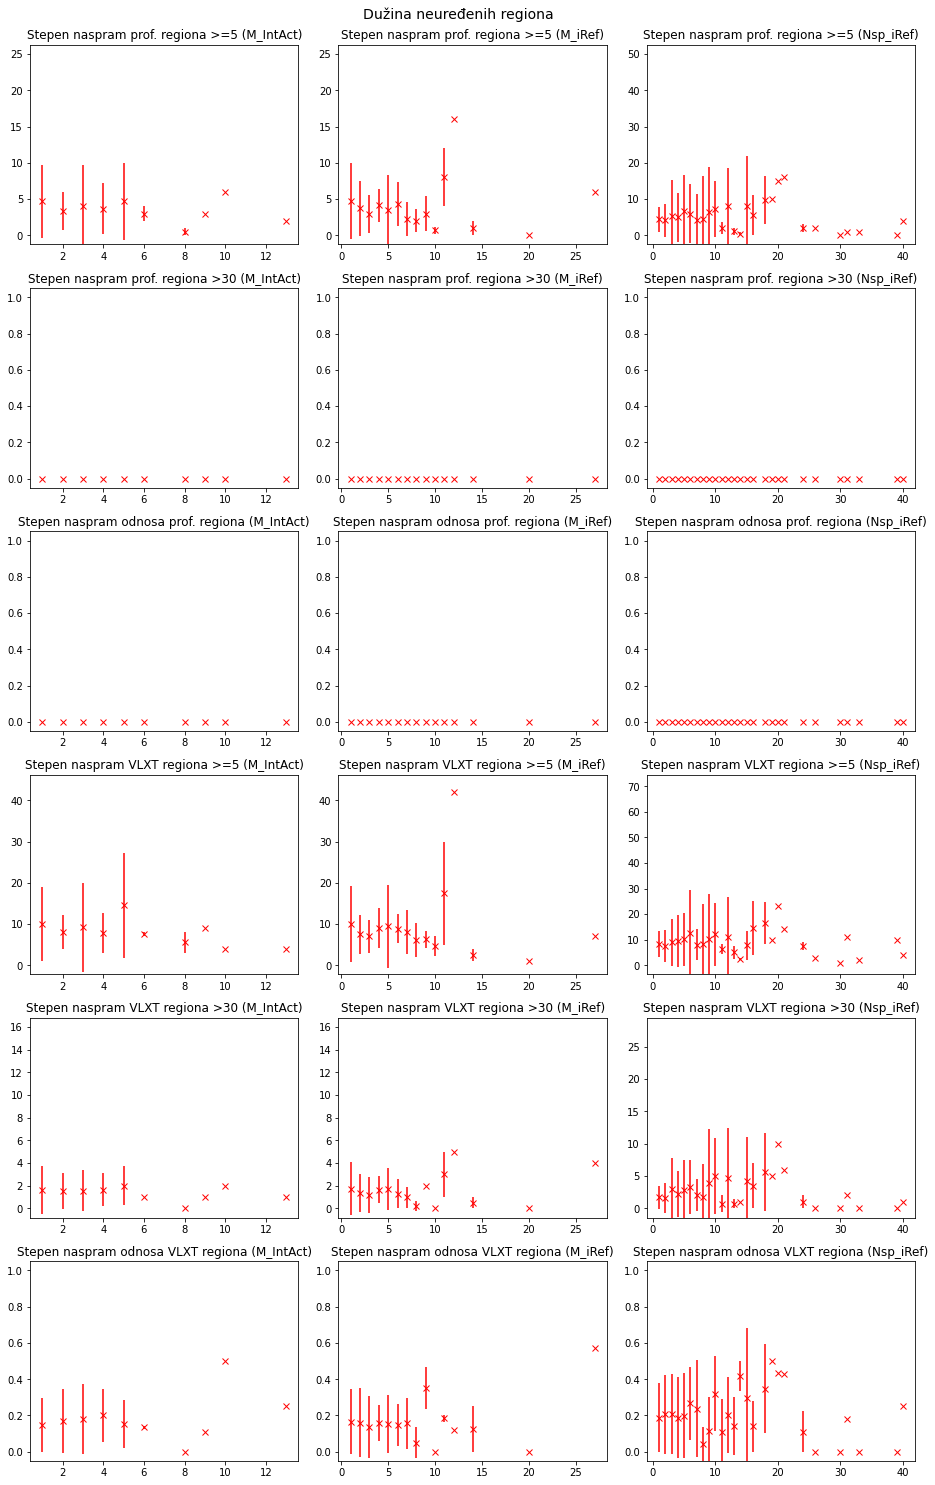

In [34]:
# Podela slike na više delova
fig, axs = plt.subplots(6, 3, figsize=(13, 21))

# Naslov grafika koji opisuje sliku
fig.suptitle('Dužina neuređenih regiona\n', fontsize=14)

# Statistike prema PONDR skorovima
statistike(M_intact, 'M_IntAct', axs[:, 0])
statistike(M_iref, 'M_iRef', axs[:, 1])
statistike(Nsp_iref, 'Nsp_iRef', axs[:, 2])

# Crtanje slike bez preklapanja
fig.tight_layout()

## 10. Drugi kraj interakcije [⮭]<a id="par:drugi"></a>

[⮭]: #par:toc

Zasad se čini da su habovi (visokopovezani čvorovi) mahom uređeni. Ipak, moguće je da je neuređenost na drugom kraju interakcije, odnosno da su uređeni habovi u vezi sa velikim brojem neuređenih interaktora. Stoga je prosečna uređenost suseda još jedna važna mera, koja je predstavljena u nastavku. Konkretno, prva prikazana mera jeste udeo neuređenih suseda prema 'tvrdom' profilu (prosek indikatora), dok je druga udeo neuređenih suseda prema *CH* predikciji (takođe prosek indikatora). Ova dva grafika izgledaju prilično zanimljivo. Treća mera predstavlja prosečan udeo aminokiselina prisutnijih u neuređenim proteinima u susedstvu, dok je četvrta prosečan udeo (*PPIDR*) predviđenih neuređenih reziduuma u susedstvu prema prediktoru *VLXT*. Čini se kao da manje povezani proteini imaju veći udeo neuređenih suseda (pri čemu su i oni sami mahom neuređeni), i obrnuto za povezanije proteine: čini se da su i habovi i njihovi susedi mahom uređeni.

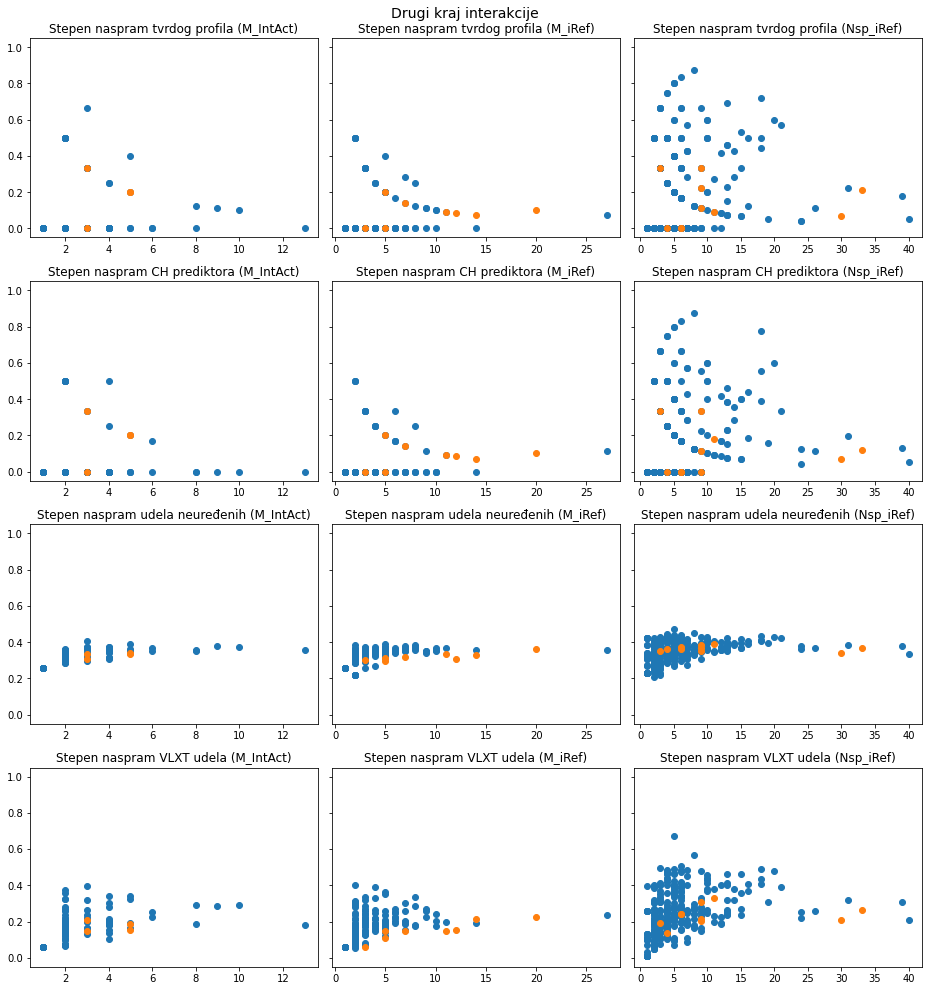

In [35]:
# Podela slike na više delova
fig, axs = plt.subplots(4, 3,
                        figsize=(13, 14),
                        sharey=True)

# Naslov grafika koji opisuje sliku
fig.suptitle('Drugi kraj interakcije', fontsize=14)

# Poređenje prema drugom kraju interakcije
def poredi(interakt, ime, axs):
    # Inicijalno prazne liste koordinata
    X, Y, Z = [], [[], [], [], []], []
    
    # Mapiranje identifikatora u objekat
    mapa = {prot.id: prot for prot in interakt.prots}

    # Prolazak kroz sve proteine
    for prot in interakt.prots:
        # Novi podaci o drugom kraju interakcije
        prot.sus_hard = np.mean([mapa[p].prof_hard for p in prot.interakt])
        prot.sus_ch = np.mean([mapa[p].ch_ind for p in prot.interakt])
        prot.sus_prof = np.mean([mapa[p].prof_ppidr for p in prot.interakt])
        prot.sus_vlxt = np.mean([mapa[p].vlxt_ppidr for p in prot.interakt])
        
        # Preskakanje polaznih
        if prot.id in interakt.ids:
            continue

        # Novi stepen povezanosti
        X.append(prot.susedi)
        
        # Novi podatak o poreklu proteina
        Z.append(prot.ljudski)
        
        # Pamćenje podataka o drugom kraju interakcije
        Y[0].append(prot.sus_hard)
        Y[1].append(prot.sus_ch)
        Y[2].append(prot.sus_prof)
        Y[3].append(prot.sus_vlxt)
    
    # Crtanje mera prema drugom kraju interakcije
    plotuj(X, Y[0], Z, axs[0], f'Stepen naspram tvrdog profila ({ime})')
    plotuj(X, Y[1], Z, axs[1], f'Stepen naspram CH prediktora ({ime})')
    plotuj(X, Y[2], Z, axs[2], f'Stepen naspram udela neuređenih ({ime})')
    plotuj(X, Y[3], Z, axs[3], f'Stepen naspram VLXT udela ({ime})')

# Poređenje prema drugom kraju interakcije
poredi(M_intact, 'M_IntAct', axs[:, 0])
poredi(M_iref, 'M_iRef', axs[:, 1])
poredi(Nsp_iref, 'Nsp_iRef', axs[:, 2])

# Crtanje slike bez preklapanja
fig.tight_layout()

I ovde su prikazane osnovne statistike uslovne raspodele neuređenosti proteina prema stepenu povezanosti čvora. Po treći put se čini da u interaktomu prema nestrukturnim proteinima prosek neuređenosti donekle raste uz porast stepena povezanosti, nakon čega naglo opada. Kada je reč o udelu aminokiselina prisutnijih u neuređenim proteinima u susedstvu, kao i prosečnom udelu predviđenih neuređenih reziduuma u susedstvu prema prediktoru *VLXT*, primetno je da su prilično stabilni (slabo varijabilni), što se vidi po niskom standardnom odstupanju, pa su time automatski najpogodniji za zaključivanje o odnosima.

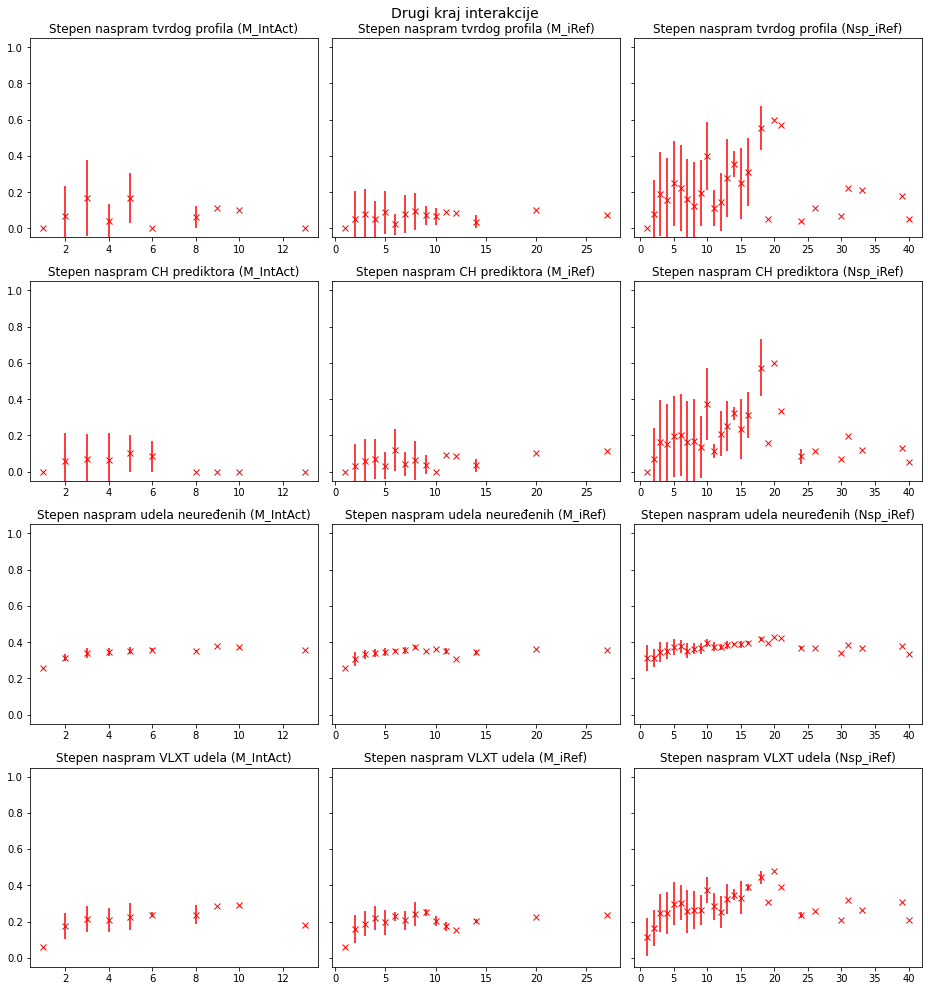

In [36]:
# Podela slike na više delova
fig, axs = plt.subplots(4, 3,
                        figsize=(13, 14),
                        sharey=True)

# Naslov grafika koji opisuje sliku
fig.suptitle('Drugi kraj interakcije', fontsize=14)

# Statistike prema drugom kraju interakcije
statistike(M_intact, 'M_IntAct', axs[:, 0])
statistike(M_iref, 'M_iRef', axs[:, 1])
statistike(Nsp_iref, 'Nsp_iRef', axs[:, 2])

# Crtanje slike bez preklapanja
fig.tight_layout()

## 11. Dužina sekvence [⮭]<a id="par:duzina"></a>

[⮭]: #par:toc

Kako dosadašnji rezultati nisu preterano zadovoljavajući, ima svrhe uporediti broj suseda sa dužinom sekvence, kao potencijalnim izvorom interaktivnosti. Čini se da u globalu duži proteini stupaju u manji broj interakcija i obrnuto, mada su prosečne vrednosti dužine slične za sve stepene povezanosti.

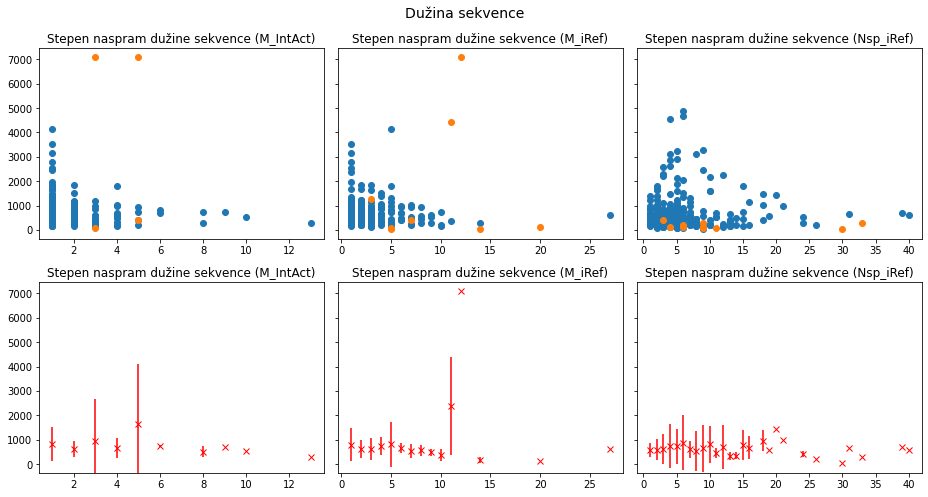

In [37]:
# Podela slike na više delova
fig, axs = plt.subplots(2, 3,
                        figsize=(13, 7),
                        sharey=True)

# Naslov grafika koji opisuje sliku
fig.suptitle('Dužina sekvence', fontsize=14)

# Poređenje prema dužini sekvence
def poredi(interakt, ime, ax):
    # Inicijalno prazne liste koordinata
    X, Y, Z = [], [], []

    # Prolazak kroz sve proteine
    for prot in interakt.prots:
        # Sekvenca prema FASTA formatu
        sekvenca = prot.fasta[prot.fasta.find('\n'):].replace('\n', '')
        
        # Dužina posmatrane sekvence
        prot.duzina = len(sekvenca)
        
        # Preskakanje polaznih
        if prot.id in interakt.ids:
            continue

        # Novi stepen povezanosti
        X.append(prot.susedi)
        
        # Novi podatak o dužini sekvence
        Y.append(prot.duzina)
        
        # Novi podatak o poreklu proteina
        Z.append(prot.ljudski)
    
    # Crtanje mera prema drugom kraju interakcije
    plotuj(X, Y, Z, ax, f'Stepen naspram dužine sekvence ({ime})')

# Poređenje prema dužini sekvence
poredi(M_intact, 'M_IntAct', axs[0, 0])
poredi(M_iref, 'M_iRef', axs[0, 1])
poredi(Nsp_iref, 'Nsp_iRef', axs[0, 2])

# Statistike prema dužini sekvence
statistike(M_intact, 'M_IntAct', axs[1, 0])
statistike(M_iref, 'M_iRef', axs[1, 1])
statistike(Nsp_iref, 'Nsp_iRef', axs[1, 2])

# Crtanje slike bez preklapanja
fig.tight_layout()

Slično važi i za poređenje stepena neuređenosti sa dužinom sekvence. Čini se da su u globalu neuređeniji duži proteini, što nije neobično. Kada se ovaj zaključak spoji sa onim iz prethodnog podnaslova, izgleda kao da manje povezani proteini imaju veći udeo neuređenih suseda (pri čemu su i oni sami mahom neuređeni), te da su mahom duži, i obrnuto za povezanije proteine: čini se da su i habovi i njihovi susedi mahom uređeni i sa kraćim sekvencama.

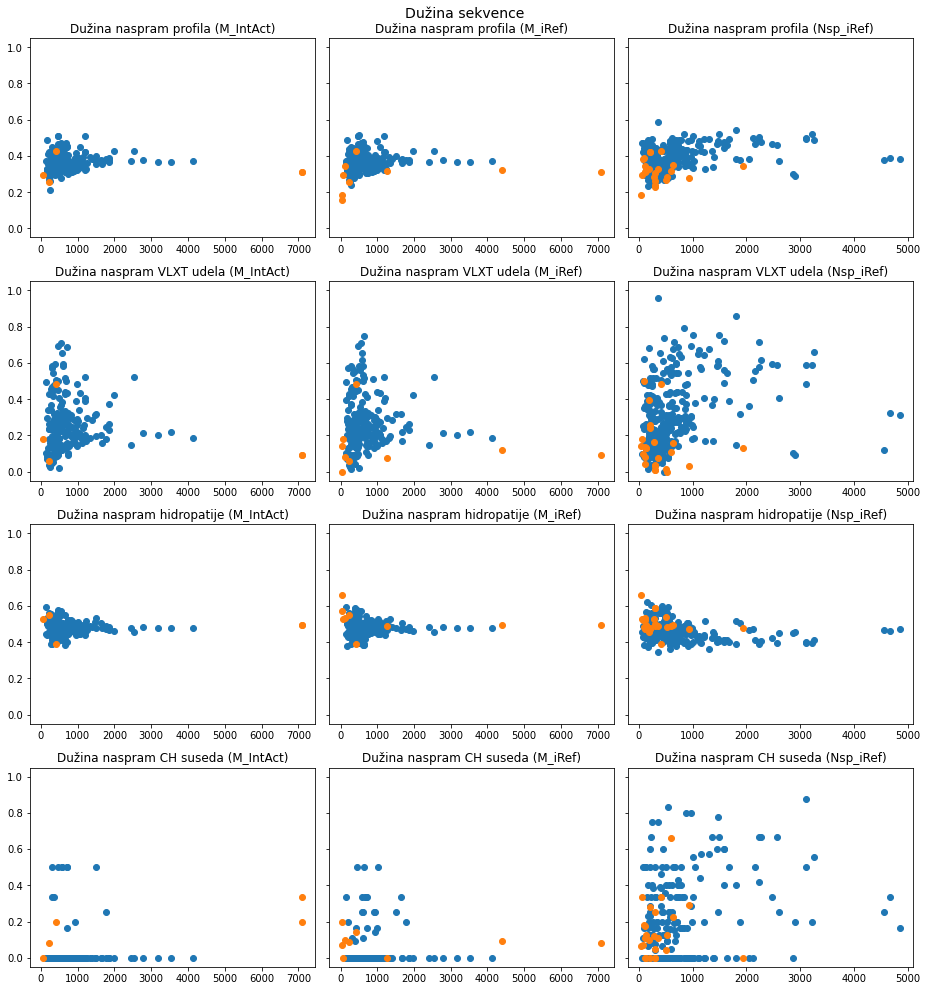

In [38]:
# Podela slike na više delova
fig, axs = plt.subplots(4, 3,
                        figsize=(13, 14),
                        sharey=True)

# Naslov grafika koji opisuje sliku
fig.suptitle('Dužina sekvence', fontsize=14)

# Poređenje prema dužini sekvence
def poredi(interakt, ime, axs):
    # Inicijalno prazne liste koordinata
    X, Y, Z = [], [[], [], [], []], []

    # Prolazak kroz sve proteine
    for prot in interakt.prots:
        # Novi podatak o dužini sekvence
        X.append(prot.duzina)
        
        # Novi podatak o poreklu proteina
        Z.append(prot.ljudski)
        
        # Novi podaci o merama neuređenosti
        Y[0].append(prot.prof_ppidr)
        Y[1].append(prot.vlxt_ppidr)
        Y[2].append(prot.ch_val)
        Y[3].append(prot.sus_ch)
    
    # Crtanje mera prema drugom kraju interakcije
    plotuj(X, Y[0], Z, axs[0], f'Dužina naspram profila ({ime})')
    plotuj(X, Y[1], Z, axs[1], f'Dužina naspram VLXT udela ({ime})')
    plotuj(X, Y[2], Z, axs[2], f'Dužina naspram hidropatije ({ime})')
    plotuj(X, Y[3], Z, axs[3], f'Dužina naspram CH suseda ({ime})')

# Poređenje prema dužini sekvence
poredi(M_intact, 'M_IntAct', axs[:, 0])
poredi(M_iref, 'M_iRef', axs[:, 1])
poredi(Nsp_iref, 'Nsp_iRef', axs[:, 2])

# Crtanje slike bez preklapanja
fig.tight_layout()

## 12. Najpovezaniji proteini [⮭]<a id="par:habovi"></a>

[⮭]: #par:toc

Kako bi eventualna dalja analiza interaktoma bila lakša, izdvojeni su najpovezaniji proteini iz svakog, kao i njihove osobine. Izdvojeni su broj suseda, dužina sekvence, podatak da li je protein ljudski ili virusni, kao i sve važne računate mere: one prema profilu, one prema *PONDR* prediktorima, one prema susedima.

In [39]:
# Spisak željenih osobina proteina
index = ['susedi', 'duzina', 'ljudski',
         'prof_hard', 'prof_soft', 'prof_ppidr',
         'prof_reg5', 'prof_reg31', 'vlxt_reg5', 'vlxt_reg31',
         'vlxt_mean', 'vlxt_ppidr', 'ch_val', 'ch_ind',
         'sus_hard', 'sus_ch', 'sus_prof', 'sus_vlxt']

# Analiza habova interaktoma
def habovi(interakt, ime, n=10):
    # Prazna tabela sa odgovarajućim indeksima
    tabela = pd.DataFrame(index=index)

    # Izdvajanje svih proteina sem polaznih
    prots = [prot for prot in interakt.prots if prot.id not in interakt.ids]

    # Sortiranje proteina prema broju suseda
    prots = sorted(prots, key=lambda prot: prot.susedi, reverse=True)

    # Tabeliranje n najpovezanijih proteina
    for prot in prots[:n]:
        # Dohvatanje svih relevantnih osobina
        spisak = [getattr(prot, k) for k in index]

         # Upisivanje sloga u tabelu
        tabela[prot.id] = spisak

    # Upisivanje na lokal za ubuduće
    with fopen(f'../habovi/{ime}_{n}.csv', 'w') as f:
        tabela.to_csv(f)
    
    # Prikaz izračunate tabele
    display(tabela)

U nastavku je analiza najpovezanijih deset proteina u interaktomu *M* (membranskog) proteina prema bazi *IntAct*.

In [40]:
# Analiza habova M_IntAct
habovi(M_intact, 'M_IntAct')

,P27105,Q7Z434,Q14164,Q8WWC4,Q9UHD2,O00471,Q8TAG9,O95786,P0DTC9,P0DTD1-PRO_0000449629
susedi,13,10,9,8,8,6,6,5,5,5
duzina,288,540,716,291,729,708,804,925,419,7096
ljudski,True,True,True,True,True,True,True,True,False,False
prof_hard,0,1,0,0,0,0,0,0,1,0
prof_soft,0.4375,0.625,0.375,0.4375,0.25,0.3125,0.125,0.3125,0.8125,0.0625
prof_ppidr,0.375,0.47037,0.375698,0.42268,0.342936,0.372881,0.35199,0.387027,0.429594,0.314262
prof_reg5,2,6,3,1,0,4,2,3,5,16
prof_reg31,0,0,0,0,0,0,0,0,0,0
vlxt_reg5,4,4,9,3,8,8,7,13,8,42
vlxt_reg31,1,2,1,0,0,1,1,0,3,5


U nastavku je analiza najpovezanijih deset proteina u interaktomu *M* (membranskog) proteina prema bazi *iRefIndex*.

In [41]:
# Analiza habova M_iRef
habovi(M_iref, 'M_iRef')

,F2YGU2,P0DTC7,A0A024R882,P0DTD8,P0DTD1,P0DTC1,Q9Y312,O75947,P48047,Q9UHD2
susedi,27,20,14,14,12,11,11,10,10,10
duzina,615,121,288,43,7096,4405,384,161,213,729
ljudski,True,False,True,False,False,False,True,True,True,True
prof_hard,0,0,0,0,0,0,0,0,0,0
prof_soft,0.5,0.1875,0.4375,0.1875,0.0625,0.125,0.25,0.5,0.5625,0.25
prof_ppidr,0.39187,0.347107,0.375,0.186047,0.314262,0.325312,0.388021,0.490683,0.422535,0.342936
prof_reg5,6,0,2,0,16,12,4,1,1,0
prof_reg31,0,0,0,0,0,0,0,0,0,0
vlxt_reg5,7,1,4,1,42,30,5,2,4,8
vlxt_reg31,4,0,1,0,5,5,1,0,0,0


U nastavku je analiza najpovezanijih deset proteina u interaktomu nestrukturnih proteina prema bazi *iRefIndex*.

In [42]:
# Analiza habova Nsp_iRef
habovi(Nsp_iref, 'Nsp_iRef')

,XP_005269747,P0CG48,P0DTC3,P11021,P0DTD8,A0A158RFU6,P00387,P06576,Q08379,XP_011535124
susedi,40,39,33,31,30,26,24,24,21,20
duzina,598,685,275,654,43,207,301,529,1002,1450
ljudski,True,True,False,True,False,True,True,True,True,True
prof_hard,0,0,0,0,0,0,0,0,1,1
prof_soft,0.5,0.625,0.1875,0.4375,0.1875,0.375,0.25,0.4375,0.6875,0.5
prof_ppidr,0.362876,0.354745,0.283636,0.382263,0.186047,0.381643,0.322259,0.379962,0.50998,0.464138
prof_reg5,4,0,1,1,0,2,1,3,16,15
prof_reg31,0,0,0,0,0,0,0,0,0,0
vlxt_reg5,4,10,2,11,1,3,6,9,14,23
vlxt_reg31,1,0,0,2,0,0,0,2,6,10
